***
**v0.1.0 | 02-Feb-2022**

* Here I explain my HF data and the methods I used to prepare and analyze it
* NB: Integrate words from separate .ipynb later to keep this file a little lighter and thus more tractable

***

# HF data

## AAPL, JPM 1-min bar data

In [11]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

# get the equity HF data (AAPL, JPM)
# path = "D:\\data\\algoseek\\allfiles"
path = "~/data/allfiles"
allFiles = glob.glob(os.path.join(path,"**/*.csv.gz"))

allFiles

CPU times: user 169 µs, sys: 89 µs, total: 258 µs
Wall time: 207 µs


[]

In [24]:
dfFX = pd.read_csv(r"data/ALL.csv", header=None, engine='python')
dfFX[:10]

,0,1,2,3,4,5,6
0,2018.01.01,17:00:00,1.20037,1.20100,1.20037,1.20100,0
1,2018.01.01,17:01:00,1.20083,1.20095,1.20017,1.20030,0
2,2018.01.01,17:02:00,1.20035,1.20043,1.20035,1.20043,0
3,2018.01.01,17:03:00,1.20041,1.20050,1.20031,1.20046,0
4,2018.01.01,17:04:00,1.20049,1.20049,1.20046,1.20048,0
5,2018.01.01,17:05:00,1.20050,1.20050,1.20048,1.20048,0
6,2018.01.01,17:06:00,1.20050,1.20069,1.20032,1.20048,0
7,2018.01.01,17:07:00,1.20048,1.20054,1.20027,1.20050,0
8,2018.01.01,17:08:00,1.20051,1.20087,1.20047,1.20087,0
9,2018.01.01,17:09:00,1.20082,1.20097,1.20076,1.20094,0


In [26]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

# get the equity HF data (AAPL, JPM)
path = "data/allfiles"
allFiles = glob.glob(os.path.join(path,"**\\*.csv.gz"))

allFiles

CPU times: user 1.24 ms, sys: 166 µs, total: 1.41 ms
Wall time: 805 µs


[]

In [1]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

# get the equity HF data (AAPL, JPM)
# path = "D:\\data\\algoseek\\allfiles"
path = "~/data/allfiles"
allFiles = glob.glob(os.path.join(path,"**\\*.csv.gz"))

np_array_list = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    np_array_list.append(df.as_matrix())

# Create a bit array, just in case an array is useful later
comb_np_array = np.vstack(np_array_list)

# Create dataframe, for visualization, etc.
bigF = pd.DataFrame(comb_np_array)

# Set column headings
bigF.columns = ["Date","Ticker","TimeBarStart","OpenBarTime","OpenBidPrice","OpenBidSize","OpenAskPrice","OpenAskSize","FirstTradeTime","FirstTradePrice","FirstTradeSize",
                     "HighBidTime","HighBidPrice","HighBidSize","HighAskTime","HighAskPrice","HighAskSize","HighTradeTime","HighTradePrice","HighTradeSize","LowBidTime","LowBidPrice",
                     "LowBidSize","LowAskTime","LowAskPrice","LowAskSize","LowTradeTime","LowTradePrice","LowTradeSize","CloseBarTime","CloseBidPrice","CloseBidSize","CloseAskPrice",
                     "CloseAskSize","LastTradeTime","LastTradePrice","LastTradeSize","MinSpread","MaxSpread","CancelSize","VolumeWeightPrice","NBBOQuoteCount","TradeAtBid","TradeAtBidMid",
                     "TradeAtMid","TradeAtMidAsk","TradeAtAsk","TradeAtCrossOrLocked","Volume","TotalTrades","FinraVolume","FinraVolumeWeightPrice","UptickVolume","DowntickVolume",
                     "RepeatUptickVolume","RepeatDowntickVolume","UnknownTickVolume","TradeToMidVolWeight","TradeToMidVolWeightRelative","TimeWeightBid","TimeWeightAsk"]

# Set a date-time index, using OpenBarTime
bigF['DateTimeIndex'] = pd.to_datetime(bigF['Date'].astype(str)) + pd.to_timedelta(bigF['OpenBarTime'].astype(str))
bigF = bigF.set_index('DateTimeIndex')

# Set datatypes and add separate Date and Time columns in case useful later
bigF['Ticker'] = bigF.Ticker.astype(str)
bigF['CloseBidSize'] = bigF.CloseBidSize.astype(float)
bigF['CloseAskSize'] = bigF.CloseAskSize.astype(float)
bigF['CloseBidPrice'] = bigF.CloseBidPrice.astype(float)
bigF['CloseAskPrice'] = bigF.CloseAskPrice.astype(float)

# Remove FINRA trades (i.e. off-exhange and dark pool trades)
# NOTE THAT THIS REMOVES 581,413 OBSERVATIONS!
# bigF = bigF.loc[bigF['FinraVolume'] == 0].copy()

# Reduce bigF to smF
smF = bigF[['Ticker','CloseBidSize','CloseAskSize','CloseBidPrice','CloseAskPrice']].copy()   # NB: take copy
smF['Date'] = pd.to_datetime(bigF['Date'].astype(str))
smF['Time'] = pd.to_timedelta(bigF['OpenBarTime'].astype(str))
smF['DateTime'] = pd.to_datetime(bigF['Date'].astype(str)) + pd.to_timedelta(bigF['OpenBarTime'].astype(str))

# Compute WeightedMidPrice using the closing prices per analysis
smF['WeightedMidPrice'] = ((smF['CloseBidSize']*smF['CloseAskPrice']) + (smF['CloseAskSize']*smF['CloseBidPrice'])) / (smF['CloseBidSize'] + smF['CloseAskSize'])

# Raw returns
AAPL_rr = smF.loc[smF['Ticker'] == "AAPL"]
AAPL_rr = AAPL_rr['WeightedMidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()
JPM_rr = smF.loc[smF['Ticker'] == "JPM"]
JPM_rr = JPM_rr['WeightedMidPrice'] - JPM_rr['WeightedMidPrice'].shift(1)
JPM_rr = JPM_rr[JPM_rr.notna()].copy()
JPM_rr = JPM_rr[JPM_rr != 0].copy()

# Log returns
AAPL_lr = smF.loc[smF['Ticker'] == "AAPL"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
JPM_lr = smF.loc[smF['Ticker'] == "JPM"]
JPM_lr = np.log(JPM_lr['WeightedMidPrice'].astype(float))
JPM_lr = JPM_lr - JPM_lr.shift(1)
JPM_lr = JPM_lr[JPM_lr.notna()].copy()
JPM_lr = JPM_lr[JPM_lr != 0].copy()

# Remove outliers
Q1l = AAPL_lr.quantile(0.001)   # Start with these quantile values, experiment with lower values
Q3l = AAPL_lr.quantile(0.999)   # Start with these quantile values, experiment with lower values if necessary
IQl = Q3l - Q1l
Q1r = AAPL_rr.quantile(0.001)   # Start with these quantile values, experiment with lower values
Q3r = AAPL_rr.quantile(0.999)   # Start with these quantile values, experiment with lower values if necessary
IQr = Q3r - Q1r
AAPL_lr = AAPL_lr[~((AAPL_lr < (Q1l - 1.5 * IQl)) | (AAPL_lr > (Q3l + 1.5 * IQl)))]
AAPL_rr = AAPL_rr[~((AAPL_rr < (Q1r - 1.5 * IQr)) | (AAPL_rr > (Q3r + 1.5 * IQr)))]
JPM_lr = JPM_lr[~((JPM_lr < (Q1l - 1.5 * IQl)) | (JPM_lr > (Q3l + 1.5 * IQl)))]
JPM_rr = JPM_rr[~((JPM_rr < (Q1r - 1.5 * IQr)) | (JPM_rr > (Q3r + 1.5 * IQr)))]

# log returns only for models split into estimate (E=60%) and out-of-forecast (F=40%)
AAPL = AAPL_lr.to_numpy(copy=True)
JPM = JPM_lr.to_numpy(copy=True)
aaplE = AAPL[0:269618,]
aaplF = AAPL[269618:,]
jpmE = JPM[0:200363,]
jpmF = JPM[200363:,]
aaplE = aaplE[:,np.newaxis]
aaplF = aaplF[:,np.newaxis]
jpmE = jpmE[:,np.newaxis]
jpmF = jpmF[:,np.newaxis]

bigF.shape, AAPL_rr.shape, JPM_rr.shape, AAPL_lr.shape, JPM_lr.shape, aaplE.shape, aaplF.shape, jpmE.shape, jpmF.shape

ValueError: need at least one array to concatenate

## EURUSD 1-min data

In [25]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

# UHF data
dfFX = pd.read_csv(r"data/ALL.csv", header=None, engine='python')     # 2018, 2019, 202001, 202002, 202003 files combined in 'ALL'
dfFX.columns = ['date','time','barOpenBid', 'barHighBid', 'barLowBid', 'barCloseBid','volume']
totalEntries1y = dfFX.shape[0]

# Set a date-time index, using time
dfFX['DateTimeIndex'] = pd.to_datetime(dfFX['date'].astype(str)) + pd.to_timedelta(dfFX['time'].astype(str))
dfFX = dfFX.set_index('DateTimeIndex')

# Set datatypes and add separate Date and Time columns in case useful later
dfFX['barOpenBid'] = dfFX.barOpenBid.astype(float)
dfFX['barHighBid'] = dfFX.barHighBid.astype(float)
dfFX['barLowBid'] = dfFX.barLowBid.astype(float)
dfFX['barCloseBid'] = dfFX.barCloseBid.astype(float)
dfFX['volume'] = dfFX.volume.astype(float)

# Raw returns
rrFX = dfFX['barCloseBid'] - dfFX['barCloseBid'].shift(1)
rrFX = rrFX[rrFX.notna()].copy()
rrFX = rrFX[rrFX != 0].copy()

# log returns
lrFX = np.log(dfFX['barCloseBid'].astype(float))
lrFX = lrFX - lrFX.shift(1)
lrFX = lrFX[lrFX.notna()].copy()
lrFX = lrFX[lrFX != 0].copy()

# Remove outliers
Q1l = lrFX.quantile(0.0001)   # Start with these quantile values, experiment with lower values
Q3l = lrFX.quantile(0.9999)   # Start with these quantile values, experiment with lower values if necessary
IQl = Q3l - Q1l
Q1r = rrFX.quantile(0.0001)   # Start with these quantile values, experiment with lower values
Q3r = rrFX.quantile(0.9999)   # Start with these quantile values, experiment with lower values if necessary
IQr = Q3r - Q1r
lrFX = lrFX[~((lrFX < (Q1l - 1.5 * IQl)) | (lrFX > (Q3l + 1.5 * IQl)))]
rrFX = rrFX[~((rrFX < (Q1r - 1.5 * IQr)) | (rrFX > (Q3r + 1.5 * IQr)))]

# log returns only for models split into estimate (E=60%) and out-of-forecast (F=40%)
FX = lrFX.to_numpy(copy=True)
fxE = FX[0:457419,]
fxF = FX[457419:,]
fxE = fxE[:,np.newaxis]
fxF = fxF[:,np.newaxis]

dfFX.shape, rrFX.shape, lrFX.shape, fxE.shape, fxF.shape

CPU times: user 6.75 s, sys: 672 ms, total: 7.43 s
Wall time: 7.42 s


((837497, 7), (762381,), (762381,), (457419, 1), (304962, 1))

# Daily returns

## DEXJPUS, simulated data

In [3]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from simulatedata import simulatedata

# Set kbar
kbar = 4

# Simulated data, 60% in-sample for estimation, 40% out-of-sample for forecasts.  See Section 4 re rationale for simulated data
b = 6
m0 = 1.6
gamma_kbar = 0.8
sig = 2/np.sqrt(252)    
T = 7087
E = np.rint(0.6*T).astype(int)            
dat1 = simulatedata(b,m0,gamma_kbar,sig,kbar,T)
dat1E = dat1[0:E,]
dat1F = dat1[E:,]

# DEXJPUS, 60% in-sample for estimation, 40% out-of-sample for forecasts
dat2 = pd.read_csv("DEXJPUS.csv")                                   
dat2 = dat2.loc[dat2.DEXJPUS != "."].DEXJPUS.astype(float)
dat2 = np.array(dat2)
dat2_rtn = dat2[0:-1]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1])
dat2 = dat2[dat2 != 0]
dat2 = dat2[:,np.newaxis]
dat2E = dat2[0:E,]
dat2F = dat2[E:,]

dat1.shape, dat1E.shape, dat1F.shape, dat2.shape, dat2E.shape, dat2F.shape

Wall time: 305 ms


((7087, 1), (4252, 1), (2835, 1), (7087, 1), (4252, 1), (2835, 1))

In [4]:
dat2

array([[-0.0044787 ],
       [ 0.00474375],
       [ 0.0005299 ],
       ...,
       [-0.01712696],
       [-0.00376239],
       [ 0.00392928]])

## DM-USD

In [7]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

dat3 = pd.read_csv("dm-usd-1973-98.csv", engine='python')
dat3 = dat3[dat3['DM-USD'] != "         ND "]

dat3['DATE'] = dat3['DATE'].str.strip()             # strip whitespace
dat3['DATE'] = pd.to_datetime(dat3['DATE'])

dat3['DM-USD'] = dat3['DM-USD'].str.strip()         # strip whitespace
dat3['DM-USD'] = pd.to_numeric(dat3['DM-USD']).astype(float)

dat3 = dat3['DM-USD']

dat3 = np.array(dat3)

dat3 = np.log(dat3[1:])-np.log(dat3[0:-1])
# dat3 = dat3[dat3 != 0]                            # Note that Calvet & Fisher don't remove zeros, to yeild 6420 entries
dat3 = dat3[:,np.newaxis]

T = len(dat3)
E = np.rint(0.6*T).astype(int)    

dat3E = dat3[0:E,]
dat3F = dat3[E:,]

dat3.shape, dat3E.shape, dat3F.shape

Wall time: 466 ms


((6419, 1), (3851, 1), (2568, 1))

In [6]:
dat3

array([[-0.02693867],
       [-0.00130473],
       [ 0.01228882],
       ...,
       [-0.00513434],
       [ 0.00346559],
       [-0.00568268]])

## Helper function | array_attributes

In [5]:
# Array attributes | https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html
def array_attributes(A):
    for attr in ('ndim', 'size', 'itemsize', 'dtype', 'shape', 'strides', 'flags',
                 'flat', 'imag', 'real', 'nbytes', 'ctypes', 'base', 'T', 'data'):
        print(f'{attr:8s}: {getattr(A, attr)}')
        
# array_attributes(dat1)
# array_attributes(dat2)
# array_attributes(dat3)

# Analysis

## Summary statistics

> **CRITICAL** | Summary statistics are presented below for **`RAW RETURNS`** | not log returns (is this correct? verify theoretically as well as to literature)

*AAPL, JPM*

In [5]:
from scipy import stats

j = stats.describe(AAPL_rr)
print("Descriptive statistics for AAPL: ","\n"
      "Number of observations = ",j.nobs,"\n"
      "Minimum, Maximum = ", str(j.minmax),"\n"
      "Mean = %.5f" %  j.mean,"\n"
      "Variance = %.5f" %  j.variance,"\n"
      "Standard deviation = %.5f" %  j.variance**0.5,"\n"
      "Skewness = %.5f" %  j.skewness,"\n"
      "Kurtosis = %.5f" %  j.kurtosis) 

k = stats.describe(JPM_rr)
print("Descriptive statistics for JPM: ","\n"
      "Number of observations = ",k.nobs,"\n"
      "Minimum, Maximum = ", str(k.minmax),"\n"
      "Mean = %.5f" %  k.mean,"\n"
      "Variance = %.5f" %  k.variance,"\n"
      "Standard deviation = %.5f" %  k.variance**0.5,"\n"
      "Skewness = %.5f" %  k.skewness,"\n"
      "Kurtosis = %.5f" %  k.kurtosis)

m = stats.describe(rrFX)
print("Descriptive statistics for HF EURUSD: ","\n"
      "Number of observations = ",m.nobs,"\n"
      "Minimum, Maximum = ",str(m.minmax),"\n"
      "Mean = %.5f" %  m.mean,"\n"
      "Variance = %.5f" %  m.variance,"\n"
      "Standard deviation = %.5f" %  m.variance**0.5,"\n"
      "Skewness = %.5f" %  m.skewness,"\n"
      "Kurtosis = %.5f" %  m.kurtosis)

k = stats.describe(dat2)
print("Descriptive statistics for DEXJPUS: ","\n"
      "Number of observations = ",k.nobs,"\n"
      "Minimum, Maximum = ",str(k.minmax),"\n"
      "Mean = %.5f" %  k.mean,"\n"
      "Variance = %.5f" %  k.variance,"\n"
      "Standard deviation = %.5f" %  k.variance**0.5,"\n"
      "Skewness = %.5f" %  k.skewness,"\n"
      "Kurtosis = %.5f" %  k.kurtosis)

j = stats.describe(dat1)
print("Descriptive statistics for Simulated Data: ","\n"
      "Number of observations = ",j.nobs,"\n"
      "Minimum, Maximum = ",str(j.minmax),"\n"
      "Mean = %.5f" %  j.mean,"\n"
      "Variance = %.5f" %  j.variance,"\n"
      "Standard deviation = %.5f" %  j.variance**0.5,"\n"
      "Skewness = %.5f" %  j.skewness,"\n"
      "Kurtosis = %.5f" %  j.kurtosis)

Descriptive statistics for AAPL:  
Number of observations =  449389 
Minimum, Maximum =  (-4.5712500000000205, 4.583235294117685) 
Mean = 0.00023 
Variance = 0.02483 
Standard deviation = 0.15758 
Skewness = 0.09255 
Kurtosis = 62.87348
Descriptive statistics for JPM:  
Number of observations =  334044 
Minimum, Maximum =  (-4.518571428571434, 4.446867167919805) 
Mean = -0.00003 
Variance = 0.02113 
Standard deviation = 0.14538 
Skewness = -0.09286 
Kurtosis = 89.57130
Descriptive statistics for HF EURUSD:  
Number of observations =  762381 
Minimum, Maximum =  (-0.0046600000000001085, 0.00666000000000011) 
Mean = -0.00000 
Variance = 0.00000 
Standard deviation = 0.00015 
Skewness = 0.49364 
Kurtosis = 46.37953
Descriptive statistics for DEXJPUS:  
Number of observations =  7087 
Minimum, Maximum =  (array([-0.05630211]), array([0.06255581])) 
Mean = -0.00011 
Variance = 0.00004 
Standard deviation = 0.00666 
Skewness = -0.38715 
Kurtosis = 5.46706
Descriptive statistics for Simulated

*Table [X]. Moments for datasets*

| | Observations | Mean | Std Dev | Skewness | Kurtosis |
| --- | --- | --- | --- | --- | --- |
| Equities AAPL HF (1-min returns) | 449389 | 0.00023 | 0.15758 | 0.09255 | 62.87348 |
| Equities JPM HF (1-min returns) | 334044 | -0.00003 | 0.14538 | -0.09286 | 89.57130 |
| FX EURUSD HF (1-min returns) | 762365 | -0.00000 | 0.00015 | 0.49364 | 46.37953 |
| DEXJPUS (daily returns) | 7087 | -0.00011 | 0.00666 | -0.38715 | 5.46706 | 
| Simulated data | 7087  | 0.00117 | 0.12705 | -0.12325 | 7.01009 |


## Volatilities

* _[This stackexchange, about two-fifths of the way down, bottom of answer posted by strimp099](https://quant.stackexchange.com/questions/2589/how-to-calculate-historical-intraday-volatility)_ <br>
* *So to answer your question in short, calculate lag-number of log returns, take the standard deviation and that's the lag-period statistical volatility of your returns.* | strimp099 <br>
* `SUPER-IMPORTANT` | _[Compare my result to this, are my results reasonable?](https://www.alphaquery.com/stock/AAPL/volatility-option-statistics/30-day/historical-volatility)_ <br>
$\\[0.1in]$

In [6]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

# Set up
n_lags = 1354        # 1 day ~ 762365/563 ~ 1354
n_days = 1          # i.e. 20 ~ 1 month, 60 ~ 1 quarter
# start = 1         # 1 = Start Jan-01-2018 i.e. for 2018
# start = 341208    # 341208 = Start Jan-19 i.e. for 2019 
# start = 682416    # 682416 = Start Jan-20 to capture Q1-20 only
# start = 735270    # 735284 = Start Mar-20 to capture March only only
start = 761000    # 761010 = Start Jan-20 to capture Q1-20 only


# Stocks (select ticker)
# i = smF.loc[smF['Ticker'] == "JPM"]
# m = np.log(i['WeightedMidPrice'].astype(float))
# m = m - m.shift(1)
# m = m[m.notna()].copy()
# m = m[m != 0].copy()
# m = m[start:start+(n_lags*n_days),]    # select a certain start point of subset

# n = i['WeightedMidPrice'].astype(float)
# n = n - n.shift(1)
# n = n[n.notna()].copy()
# n = n[n != 0].copy()
# n = n[start:start+(n_lags*n_days),]    # select a certain start point of subset

# EURUSD
m = np.log(dfFX['barCloseBid'].astype(float))
m = m - m.shift(1)
m = m[m.notna()].copy()
m = m[m != 0].copy()
m = m[start:start+(n_lags*n_days),]    # select a certain start point of subset

n = dfFX['barCloseBid'].astype(float)
n = n - n.shift(1)
n = n[n.notna()].copy()
n = n[n != 0].copy()
n = n[start:start+(n_lags*n_days),]    # select a certain start point of subset

m.shape, n.shape

((1354,), (1354,))

In [7]:
j = stats.describe(n)
k = stats.describe(m)
print('Vol as % using raw returns = ', (j.variance**0.5)*100)
print('Vol as % using log returns = ', (k.variance**0.5)*100)

Vol as % using raw returns =  0.027184702968674094
Vol as % using log returns =  0.02474167558748306


*Table [X]. Volatilities (1 year (2018 and 2019), 1-quarter (Q1-2020), 30 day (March 2020) and 1 day (31st March 2020) standard deviations in % for HF datasets*

| | 2018-FY | 2019-FY | 2020-Q1 | 30-Day | 1-Day |
| --- | --- | --- | --- | --- | --- |
| **AAPL** |
| CloseBidPrice | 14.24 | 13.36 | 46.27 | 60.17 | 28.77 |
| CloseAskPrice | 14.35 | 13.54 | 45.58 | 60.16 | 27.74 |
| WeightedMidPrice | 12.75 | 11.98 | 40.66 | 56.72 | 28.52 |
| Realized Vol | ----- | ----- | ----- | ----- | ----- |
| **JPM** |
| CloseBidPrice | 14.32 | 16.32 | 23.46 | 30.34 | 27.76 |
| CloseAskPrice | 13.84 | 12.72 | 31.98 | 39.22 | 33.09 |
| WeightedMidPrice | 13.92 | 11.99 | 25.48 | 36.77 | 31.72 |
| Realized Vol | ----- | ----- | ----- | ----- | ----- |
| **EURUSD** |
| CloseBidPrice | 0.015 | 0.011 | 0.021 | 0.036 | 0.028 |
| CloseAskPrice | 0.015 | 0.011 | 0.020 | 0.034 | 0.026 |
| WeightedMidPrice | 0.015 | 0.011 | 0.021 | 0.033 | 0.027 |
| Realized Vol | ----- | ----- | ----- | ----- | ----- |

*Commentary:* <br>
> * **`INTERESTING`** | If I compare the results above to the volatilities shown __[here](https://www.alphaquery.com/stock/JPM/volatility-option-statistics/30-day/historical-volatility)__, which are `close-to-close` (assume that means closing price to closing price), then my volatlities are very much lower in the period of high volatility in 2020-Q1 and March-2020 particularly. <br>
> * **`WHY??`** <br>

## Returns plots

In [8]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns   
sns.set()

startEndTimes = ['2018-01-01 00:00:00.0', '2020-03-31 23:59:59.0']
startTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[0])
endTime = pd._libs.tslibs.timestamps.Timestamp(startEndTimes[1])
startDate = str(startTime.date()).replace('-','.')
endDate = str(endTime.date()).replace('-','.')
currentTime = str(date.today())

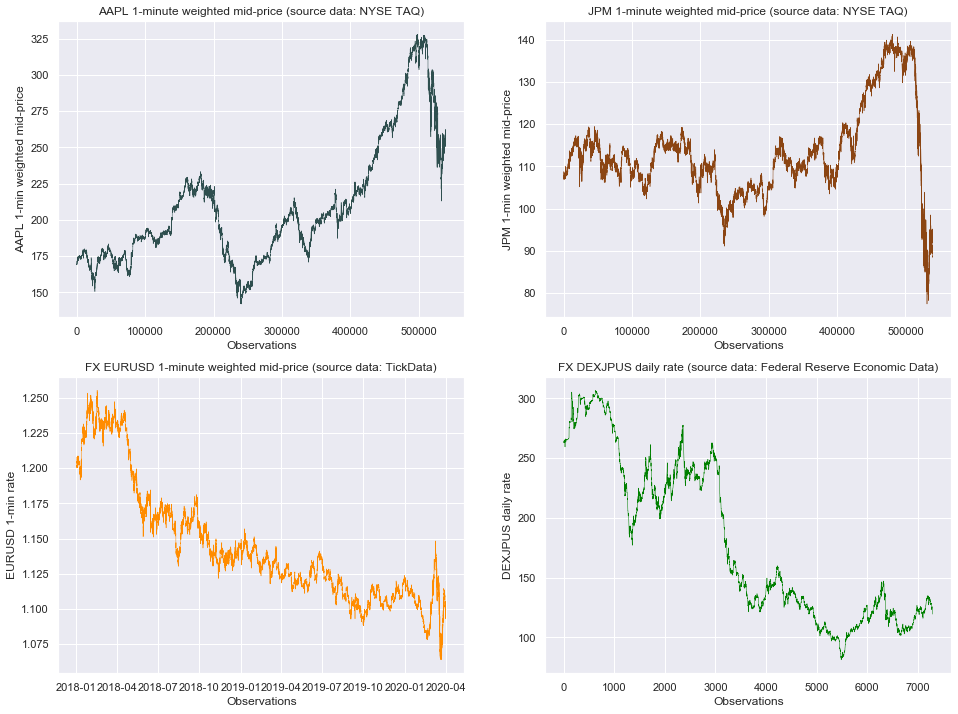

In [9]:
from scipy import stats
import seaborn as sns; sns.set()
fig = plt.figure(figsize=(16,12))  

j = smF.loc[smF['Ticker'] == "AAPL"]
j = j['WeightedMidPrice']
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price");
ax1.plot(j, color='darkslategrey', linewidth=0.5)

j = smF.loc[smF['Ticker'] == "JPM"]
j = j['WeightedMidPrice']
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price") 
ax2.plot(j, color='saddlebrown', linewidth=0.5)

j = dfFX['barCloseBid']
j = j[j != 0].copy()
ax3 = plt.subplot(223)
ax3.set(title="FX EURUSD 1-minute weighted mid-price (source data: TickData)", xlabel="Observations", ylabel="EURUSD 1-min rate") 
ax3.plot(j, color='darkorange', linewidth=0.5)

j = np.array(dat2_rtn).astype(float)
j = j[j != 0].copy()
ax4 = plt.subplot(224)
ax4.set(title="FX DEXJPUS daily rate (source data: Federal Reserve Economic Data)", xlabel="Observations", ylabel="DEXJPUS daily rate") 
ax4.plot(j, color='green', linewidth=0.5)

plt.show();

## Log returns plots

*Figure X. AAPL, JPM, EURUSD HF Weighted Mid-Price log returns from 01-01-2018 to 31-03-2020, and DEXJPUS daily log returns from 01-06-1973 to 28-06-2002*

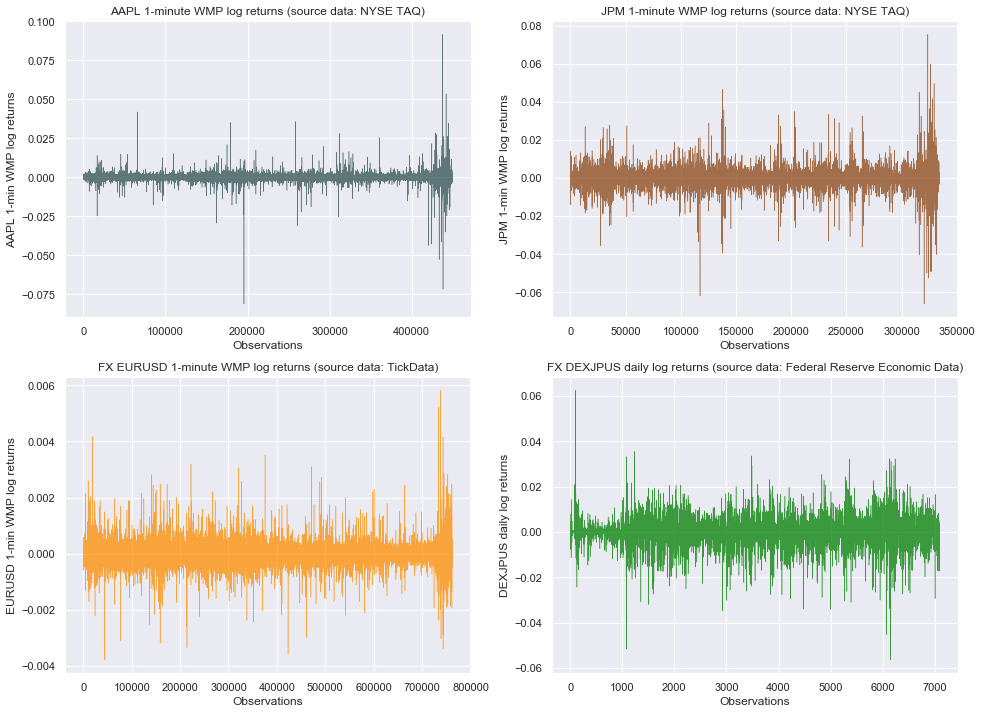

In [10]:
from scipy import stats
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(16,12))  

# Log returns (NB: shown without removal of outliers)
AAPL_lr = smF.loc[smF['Ticker'] == "AAPL"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
JPM_lr = smF.loc[smF['Ticker'] == "JPM"]
JPM_lr = np.log(JPM_lr['WeightedMidPrice'].astype(float))
JPM_lr = JPM_lr - JPM_lr.shift(1)
JPM_lr = JPM_lr[JPM_lr.notna()].copy()
JPM_lr = JPM_lr[JPM_lr != 0].copy()

j = np.array(AAPL_lr).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min WMP log returns");
ax1.plot(j, color='darkslategrey', linewidth=0.5, alpha=0.75)

j = np.array(JPM_lr).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min WMP log returns") 
ax2.plot(j, color='saddlebrown', linewidth=0.5, alpha=0.75)

j = np.array(lrFX).astype(float)
j = j[j != 0].copy()
ax3 = plt.subplot(223)
ax3.set(title="FX EURUSD 1-minute WMP log returns (source data: TickData)", xlabel="Observations", ylabel="EURUSD 1-min WMP log returns") 
ax3.plot(j, color='darkorange', linewidth=0.5, alpha=0.75)

j = np.array(dat2).astype(float)
j = j[j != 0].copy()
ax4 = plt.subplot(224)
ax4.set(title="FX DEXJPUS daily log returns (source data: Federal Reserve Economic Data)", xlabel="Observations", ylabel="DEXJPUS daily log returns") 
ax4.plot(j, color='green', linewidth=0.5, alpha=0.75)

plt.show();

## QQ plots

*Motivation*
> engle_nobel_lecture_04.pdf (key papers folder) | p411

*Sources:* 
> * _[stackoverflow](https://stackoverflow.com/questions/46935289/quantile-quantile-plot-using-seaborn-and-scipy)_
> * _[Q-Q plot wiki](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)_
> * _[scipy.stats.probplot](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)_

*Figure X. Q–Q (Quantile-Quantile) plots for AAPL, JPM, EURUSD HF Weighted Mid-Prices from 01-01-2018 to 31-03-2020, and DEXJPUS daily rates from 01-06-1973 to 28-06-2002*

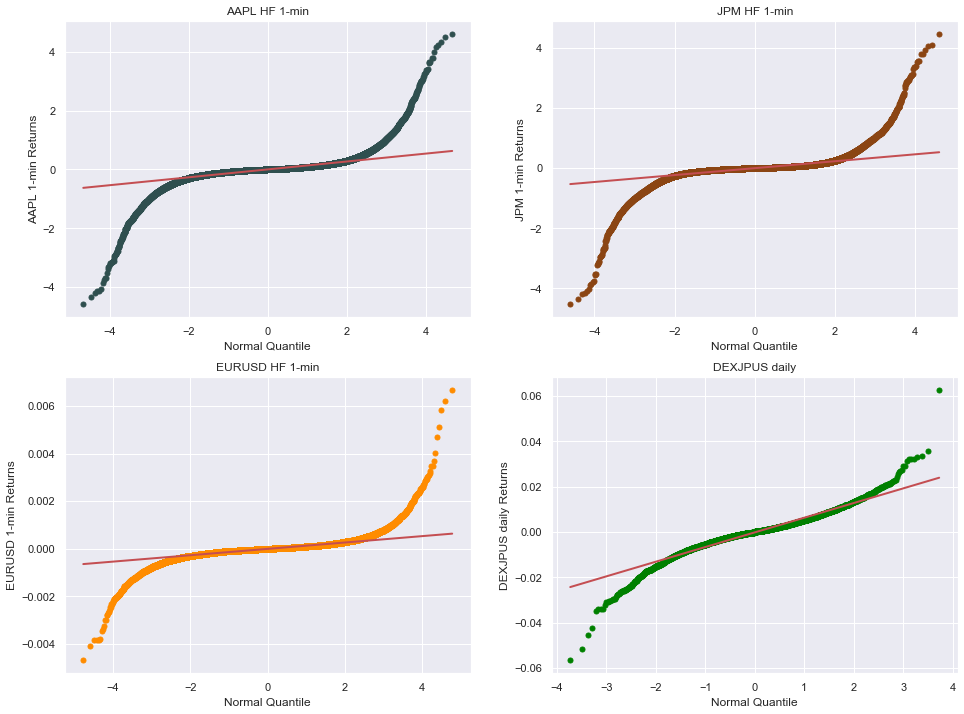

In [11]:
from scipy import stats
import seaborn as sns; sns.set()
from seaborn_qqplot import qqplot
fig = plt.figure(figsize=(16,12))  
np.random.seed(7654321)

s = np.array(AAPL_rr).astype(float)
s = s[s != 0].copy()
ax1 = plt.subplot(221)
res = stats.probplot(s, plot=sns.mpl.pyplot);
ax1.set(title="AAPL HF 1-min", xlabel="Normal Quantile", ylabel="AAPL 1-min Returns");
ax1.get_lines()[0].set_marker('o')
ax1.get_lines()[0].set_markerfacecolor('darkslategrey')
ax1.get_lines()[0].set_markeredgecolor('darkslategrey')
ax1.get_lines()[0].set_markersize(5.0)
ax1.get_lines()[1].set_linewidth(2.0)

s = np.array(JPM_rr).astype(float)
s = s[s != 0].copy()
ax2 = plt.subplot(222)
res = stats.probplot(s, plot=sns.mpl.pyplot);
ax2.set(title="JPM HF 1-min", xlabel="Normal Quantile", ylabel="JPM 1-min Returns") 
ax2.get_lines()[0].set_marker('o')
ax2.get_lines()[0].set_markerfacecolor('saddlebrown')
ax2.get_lines()[0].set_markeredgecolor('saddlebrown')
ax2.get_lines()[0].set_markersize(5.0)
ax2.get_lines()[1].set_linewidth(2.0)

s = np.array(rrFX).astype(float)
s = s[s != 0].copy()
ax3 = plt.subplot(223)
res = stats.probplot(s, plot=sns.mpl.pyplot);
ax3.set(title="EURUSD HF 1-min", xlabel="Normal Quantile", ylabel="EURUSD 1-min Returns") 
ax3.get_lines()[0].set_marker('o')
ax3.get_lines()[0].set_markerfacecolor('darkorange')
ax3.get_lines()[0].set_markeredgecolor('darkorange')
ax3.get_lines()[0].set_markersize(5.0)
ax3.get_lines()[1].set_linewidth(2.0)

s = np.array(dat2).astype(float)
s = s[s != 0].copy()
ax4 = plt.subplot(224)
res = stats.probplot(s, plot=sns.mpl.pyplot);
ax4.set(title="DEXJPUS daily", xlabel="Normal Quantile", ylabel="DEXJPUS daily Returns") 
ax4.get_lines()[0].set_marker('o')
ax4.get_lines()[0].set_markerfacecolor('green')
ax4.get_lines()[0].set_markeredgecolor('green')
ax4.get_lines()[0].set_markersize(5.0)
ax4.get_lines()[1].set_linewidth(2.0)

plt.show()

## Autocorrelograms | Diurnal patterns & high resolution view

> _[Source re searching between two dates](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)_

> **`OBJECTIVE`** | TRY TO OBSERVE DIURNAL PATTERNS & PROVIDE HIGH RESOLUTION VIEW OF WEIGHTED MID PRICE EFFECT ON AUTOCORRELATION

In [12]:
# AAPL
u = smF.loc[smF['Ticker'] == "JPM"]     
u = np.log(u['CloseBidPrice'].astype(float))
u = u - u.shift(1)
u = u[u.notna()].copy()
u = u[u != 0].copy()
u = u['2020-03-31 00:00:01':'2020-03-31 23:59:59']

v = smF.loc[smF['Ticker'] == "JPM"]
v = np.log(v['CloseAskPrice'].astype(float))
v = v - v.shift(1)
v = v[v.notna()].copy()
v = v[v != 0].copy()
v = v['2020-03-31 00:00:01':'2020-03-31 23:59:59']

w = smF.loc[smF['Ticker'] == "JPM"]
w = np.log(w['WeightedMidPrice'].astype(float))
w = w - w.shift(1)
w = w[w.notna()].copy()
w = w[w != 0].copy()
w = w['2020-03-31 00:00:01':'2020-03-31 23:59:59']

sig = 0.05          # sig = significance level, which I set at 0.05
zero = False        # Flag re to include (or not) the 0-lag autocorrelation. 
n_lags = 500

u.shape, v.shape, w.shape

((564,), (571,), (766,))

*Figure [X]. High resolution view of 1-day (March 31st) and the effect of the Weighted Mid Price on autocorrelation. Also, the diurnal patterns*

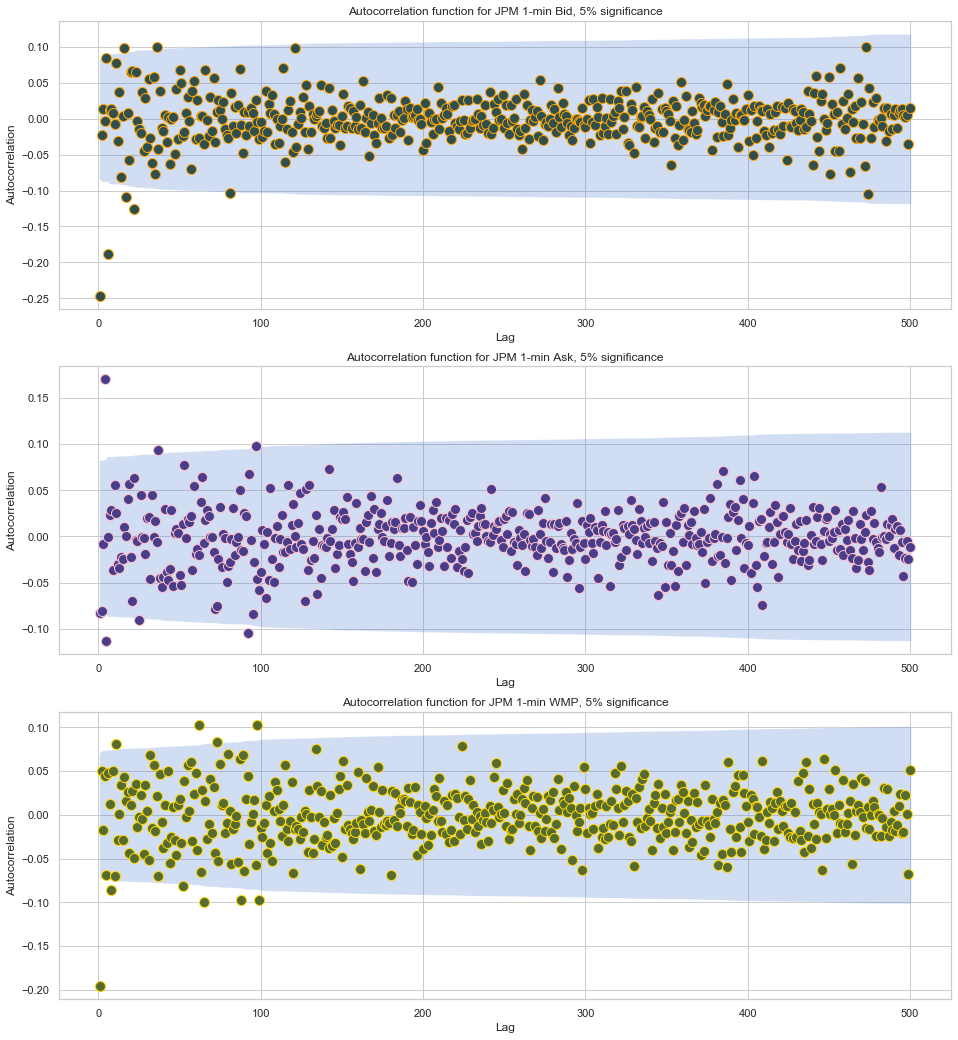

In [13]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

fig, ax = plt.subplots(3, figsize=(16,18));

# u, v, w = 31-Mar-20 only
# m, n, p = full dataset

sm.graphics.tsa.plot_acf(u, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='darkslategrey', markeredgecolor='orange', markersize=10);
sm.graphics.tsa.plot_acf(v, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[1], marker='o', markerfacecolor='darkslateblue', markeredgecolor='pink', markersize=10);
sm.graphics.tsa.plot_acf(w, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[2], marker='o', markerfacecolor='darkolivegreen', markeredgecolor='gold', markersize=10);

ax[0].set(title="Autocorrelation function for JPM 1-min Bid, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelation function for JPM 1-min Ask, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelation function for JPM 1-min WMP, 5% significance", xlabel="Lag", ylabel="Autocorrelation");

plt.show();

## Autocorrelograms | DEXJPUS

> _[Source re searching between two dates](https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)_

> **`OBJECTIVE`** | WHAT DOES DEXJPUS (I.E. DAILY RETURNS) SHOW AND WHAT CAN BE LEARNED FROM THE COMPARISON? ALSO, WHAT DOES FX SHOW - I.E. BOTH DAILY AND 1-MIN RETURNS?

*Figure [X]. FX autocorrelograms, EURUSD 1-minute returns with 1354 lags (approximately 1 day), and DEXJPUS daily returns with 50 and 500 lags respectively*

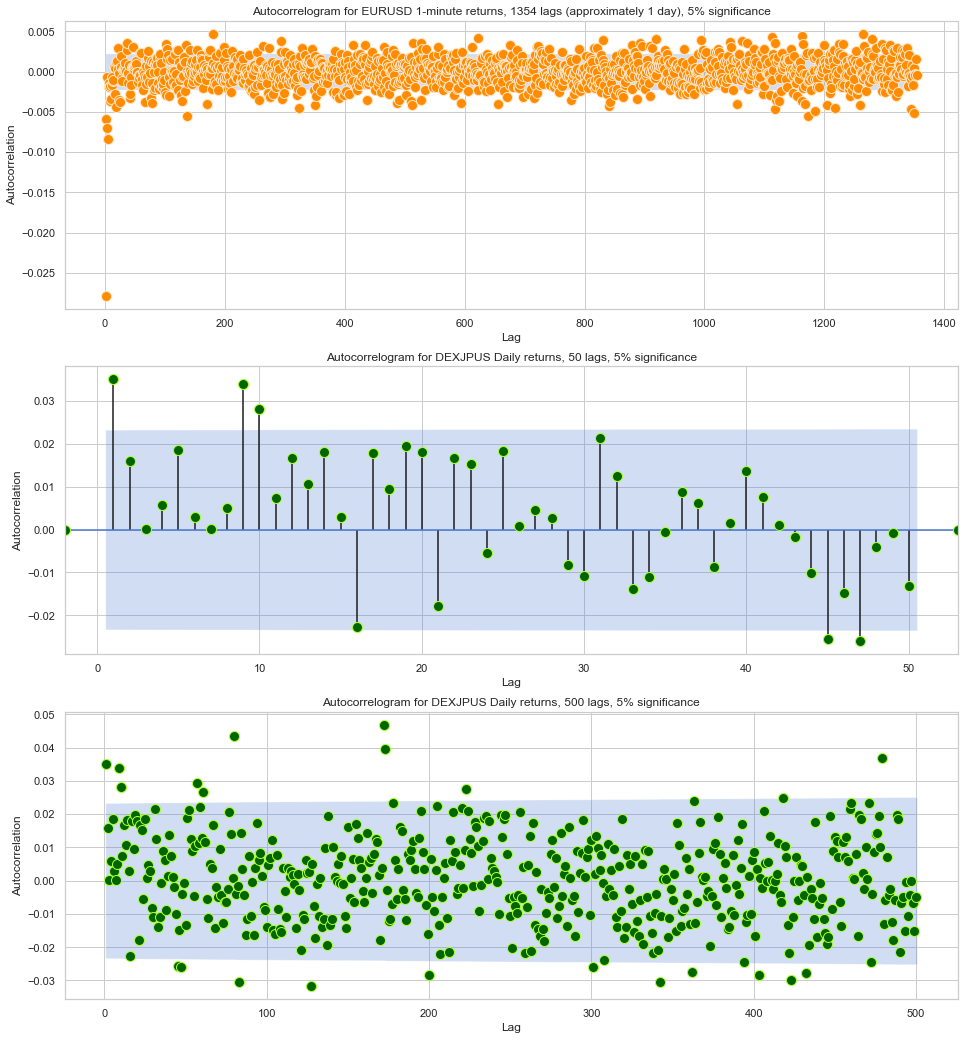

In [14]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

fig, ax = plt.subplots(3, figsize=(16,18));

sm.graphics.tsa.plot_acf(FX, lags=1354, alpha=0.05, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='darkorange', markeredgecolor='bisque', markersize=10);
sm.graphics.tsa.plot_acf(dat2, lags=50, alpha=0.05, use_vlines=True, zero=False, fft=True, ax=ax[1], marker='o', markerfacecolor='darkgreen', markeredgecolor='greenyellow', markersize=10);
sm.graphics.tsa.plot_acf(dat2, lags=500, alpha=0.05, use_vlines=False, zero=False, fft=True, ax=ax[2], marker='o', markerfacecolor='darkgreen', markeredgecolor='greenyellow', markersize=10);

ax[0].set(title="Autocorrelogram for EURUSD 1-minute returns, 1354 lags (approximately 1 day), 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelogram for DEXJPUS Daily returns, 50 lags, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelogram for DEXJPUS Daily returns, 500 lags, 5% significance", xlabel="Lag", ylabel="Autocorrelation");

plt.show();

## Autocorrelograms | sample log returns (all arranged in a panel)

*Set up the squared returns*

In [15]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

# Autocorrelation computation using numpy.corrcoef
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

# Set up | NB: lags equate to roughly 1-day
n_lags_a = 798      # 1 day, NB | i.shape = 353545, j.shape = 349845, k.shape = 449398
n_lags_j = 593      # 1 day, NB | m.shape = 264334, n.shape = 257702, p.shape = 334048
n_lags_fx = 1354    # 1 day, NB | q.shape = 762381, r.shape = 762381, s.shape = 762381
sig = 0.05          # sig = significance level, which I set at 0.05
zero = False        # Flag re to include (or not) the 0-lag autocorrelation. 

# AAPL
i = smF.loc[smF['Ticker'] == "AAPL"]     
i = np.log(i['CloseBidPrice'].astype(float))
i = i - i.shift(1)
i = i[i.notna()].copy()
i = i[i != 0].copy()

j = smF.loc[smF['Ticker'] == "AAPL"]
j = np.log(j['CloseAskPrice'].astype(float))
j = j - j.shift(1)
j = j[j.notna()].copy()
j = j[j != 0].copy()

k = smF.loc[smF['Ticker'] == "AAPL"]
k = np.log(k['WeightedMidPrice'].astype(float))
k = k - k.shift(1)
k = k[k.notna()].copy()
k = k[k != 0].copy()

# JPM
m = smF.loc[smF['Ticker'] == "JPM"]
m = np.log(m['CloseBidPrice'].astype(float))
m = m - m.shift(1)
m = m[m.notna()].copy()
m = m[m != 0].copy()

n = smF.loc[smF['Ticker'] == "JPM"]
n = np.log(n['CloseAskPrice'].astype(float))
n = n - n.shift(1)
n = n[n.notna()].copy()
n = n[n != 0].copy()

p = smF.loc[smF['Ticker'] == "JPM"]
p = np.log(p['WeightedMidPrice'].astype(float))
p = p - p.shift(1)
p = p[p.notna()].copy()
p = p[p != 0].copy()

# EURUSD
q = lrFX

r = lrFX
r = r[250000:,]     # select a different sub-population

s = lrFX
# s = s[761025:,]      # select final day of dataset (31-Mar-2020) based on {dataset.shape-n_lags} | REM to compute autocorrelations (for table below)
Q1l = s.quantile(0.001)   # Start with these quantile values, experiment with lower values
Q3l = s.quantile(0.999)   # Start with these quantile values, experiment with lower values if necessary
IQl = Q3l - Q1l
s = s[~((s < (Q1l - 1.5 * IQl)) | (s > (Q3l + 1.5 * IQl)))]

i.shape, j.shape, k.shape, m.shape, n.shape, p.shape, q.shape, r.shape, s.shape

((353545,),
 (349845,),
 (449398,),
 (264334,),
 (257702,),
 (334048,),
 (762381,),
 (512381,),
 (762365,))

*Figure [X]. Autocorrelograms for AAPL, JPM, EURUSD 1-minute samples; Bid, Ask, and Weighted Mid-Prices with 798, 593, and 1354 (i.e. 1 day equivalent) lags respectively. 5% significance bands shown as darker grey zones*

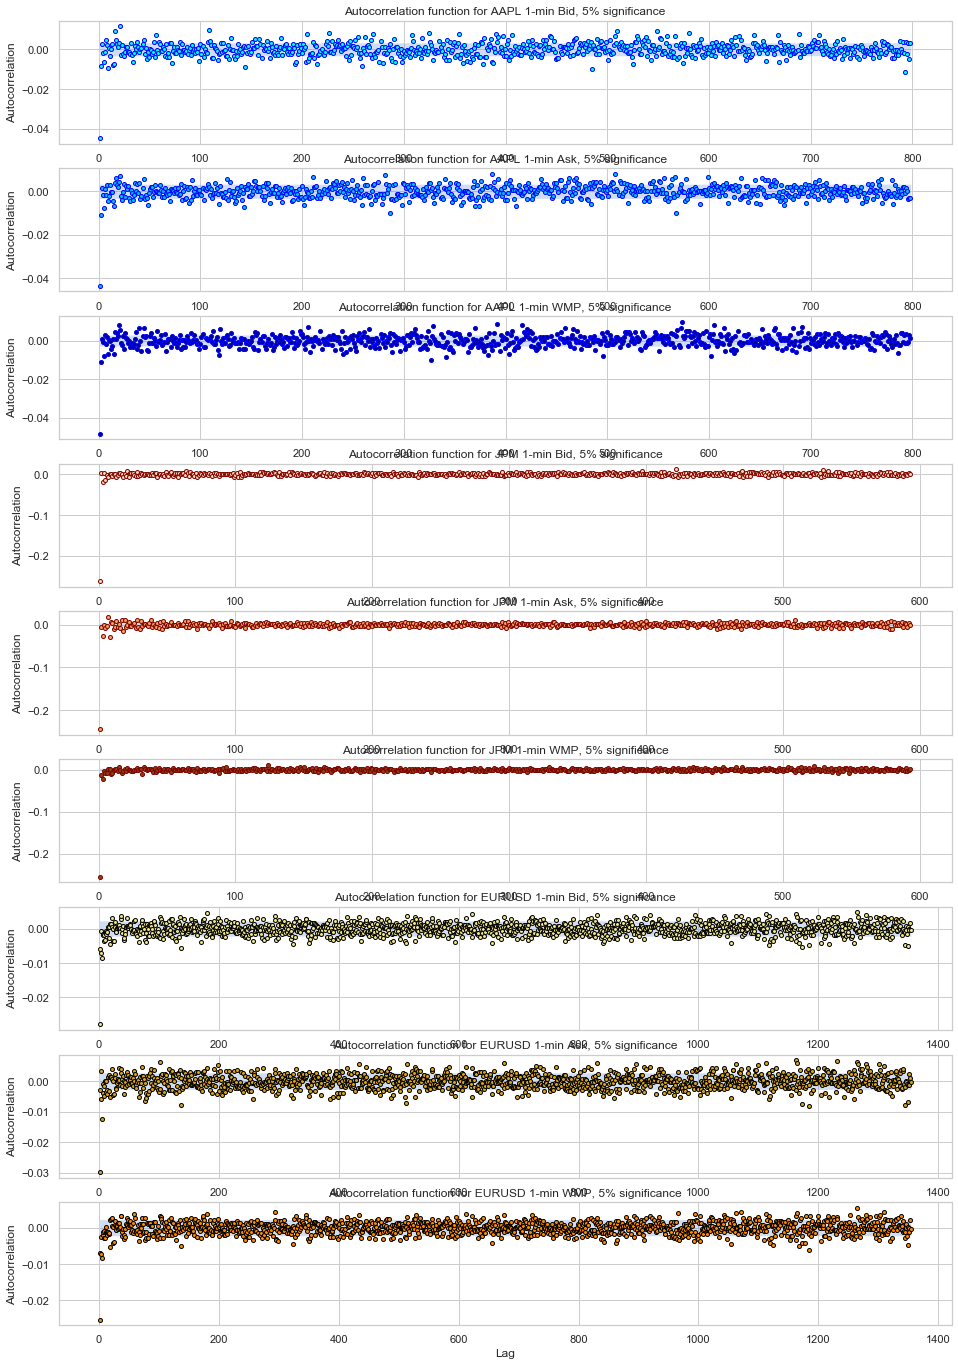

In [16]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

fig, ax = plt.subplots(9, figsize=(16,24));

sm.graphics.tsa.plot_acf(i, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='cyan', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(j, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[1], marker='o', markerfacecolor='deepskyblue', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(k, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[2], marker='o', markerfacecolor='darkblue', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(m, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[3], marker='o', markerfacecolor='peachpuff', markeredgecolor='maroon', markersize=4);
sm.graphics.tsa.plot_acf(n, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[4], marker='o', markerfacecolor='sandybrown', markeredgecolor='maroon', markersize=4);
sm.graphics.tsa.plot_acf(p, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[5], marker='o', markerfacecolor='saddlebrown', markeredgecolor='maroon', markersize=4);   
sm.graphics.tsa.plot_acf(q, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[6], marker='o', markerfacecolor='khaki', markeredgecolor='black', markersize=4);
sm.graphics.tsa.plot_acf(r, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[7], marker='o', markerfacecolor='goldenrod', markeredgecolor='black', markersize=4);
sm.graphics.tsa.plot_acf(s, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[8], marker='o', markerfacecolor='darkorange', markeredgecolor='black', markersize=4);

ax[0].set(title="Autocorrelation function for AAPL 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelation function for AAPL 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelation function for AAPL 1-min WMP, 5% significance", ylabel="Autocorrelation");
ax[3].set(title="Autocorrelation function for JPM 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[4].set(title="Autocorrelation function for JPM 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[5].set(title="Autocorrelation function for JPM 1-min WMP, 5% significance", ylabel="Autocorrelation");
ax[6].set(title="Autocorrelation function for EURUSD 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[7].set(title="Autocorrelation function for EURUSD 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[8].set(title="Autocorrelation function for EURUSD 1-min WMP, 5% significance", xlabel="Lag", ylabel="Autocorrelation");

plt.show();

## Autocorrelograms | sample squared returns, re persistence (all arranged in a panel)

*Set up the squared returns*

In [17]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

# Autocorrelation computation using numpy.corrcoef
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

# Set up | NB: lags equate to roughly 1-day
n_lags_a = 798      # 1 day, NB | i.shape = 353545, j.shape = 349845, k.shape = 449398
n_lags_j = 593      # 1 day, NB | m.shape = 264334, n.shape = 257702, p.shape = 334048
n_lags_fx = 1354    # 1 day, NB | q.shape = 762381, r.shape = 762381, s.shape = 762381
sig = 0.05          # sig = significance level, which I set at 0.05
zero = False        # Flag re to include (or not) the 0-lag autocorrelation. 

# AAPL
i = smF.loc[smF['Ticker'] == "AAPL"]     
i = np.log(i['CloseBidPrice'].astype(float))
i = i - i.shift(1)
i = i[i.notna()].copy()
i = i[i != 0].copy()
i = i**2

j = smF.loc[smF['Ticker'] == "AAPL"]
j = np.log(j['CloseAskPrice'].astype(float))
j = j - j.shift(1)
j = j[j.notna()].copy()
j = j[j != 0].copy()
j = j**2

k = smF.loc[smF['Ticker'] == "AAPL"]
k = np.log(k['WeightedMidPrice'].astype(float))
k = k - k.shift(1)
k = k[k.notna()].copy()
k = k[k != 0].copy()
k = k**2

# JPM
m = smF.loc[smF['Ticker'] == "JPM"]
m = np.log(m['CloseBidPrice'].astype(float))
m = m - m.shift(1)
m = m[m.notna()].copy()
m = m[m != 0].copy()
m = m**2

n = smF.loc[smF['Ticker'] == "JPM"]
n = np.log(n['CloseAskPrice'].astype(float))
n = n - n.shift(1)
n = n[n.notna()].copy()
n = n[n != 0].copy()
n = n**2

p = smF.loc[smF['Ticker'] == "JPM"]
p = np.log(p['WeightedMidPrice'].astype(float))
p = p - p.shift(1)
p = p[p.notna()].copy()
p = p[p != 0].copy()
p = p**2

# EURUSD
q = lrFX
q = q**2

r = lrFX
r = r[250000:,]     # select a different sub-population
r = r**2

s = lrFX
# s = s[761025:,]      # select final day of dataset (31-Mar-2020) based on {dataset.shape-n_lags} | REM to compute autocorrelations (for table below)
Q1l = s.quantile(0.001)   # Start with these quantile values, experiment with lower values
Q3l = s.quantile(0.999)   # Start with these quantile values, experiment with lower values if necessary
IQl = Q3l - Q1l
s = s[~((s < (Q1l - 1.5 * IQl)) | (s > (Q3l + 1.5 * IQl)))]
s = s**2

i.shape, j.shape, k.shape, m.shape, n.shape, p.shape, q.shape, r.shape, s.shape

((353545,),
 (349845,),
 (449398,),
 (264334,),
 (257702,),
 (334048,),
 (762381,),
 (512381,),
 (762365,))

*Figure [X]. Autocorrelograms for AAPL, JPM, EURUSD squared 1-minute samples; Bid, Ask, and Weighted Mid-Prices with 798, 593, and 1354 (i.e. 1 day equivalent) lags respectively. 5% significance bands shown as darker grey zones*

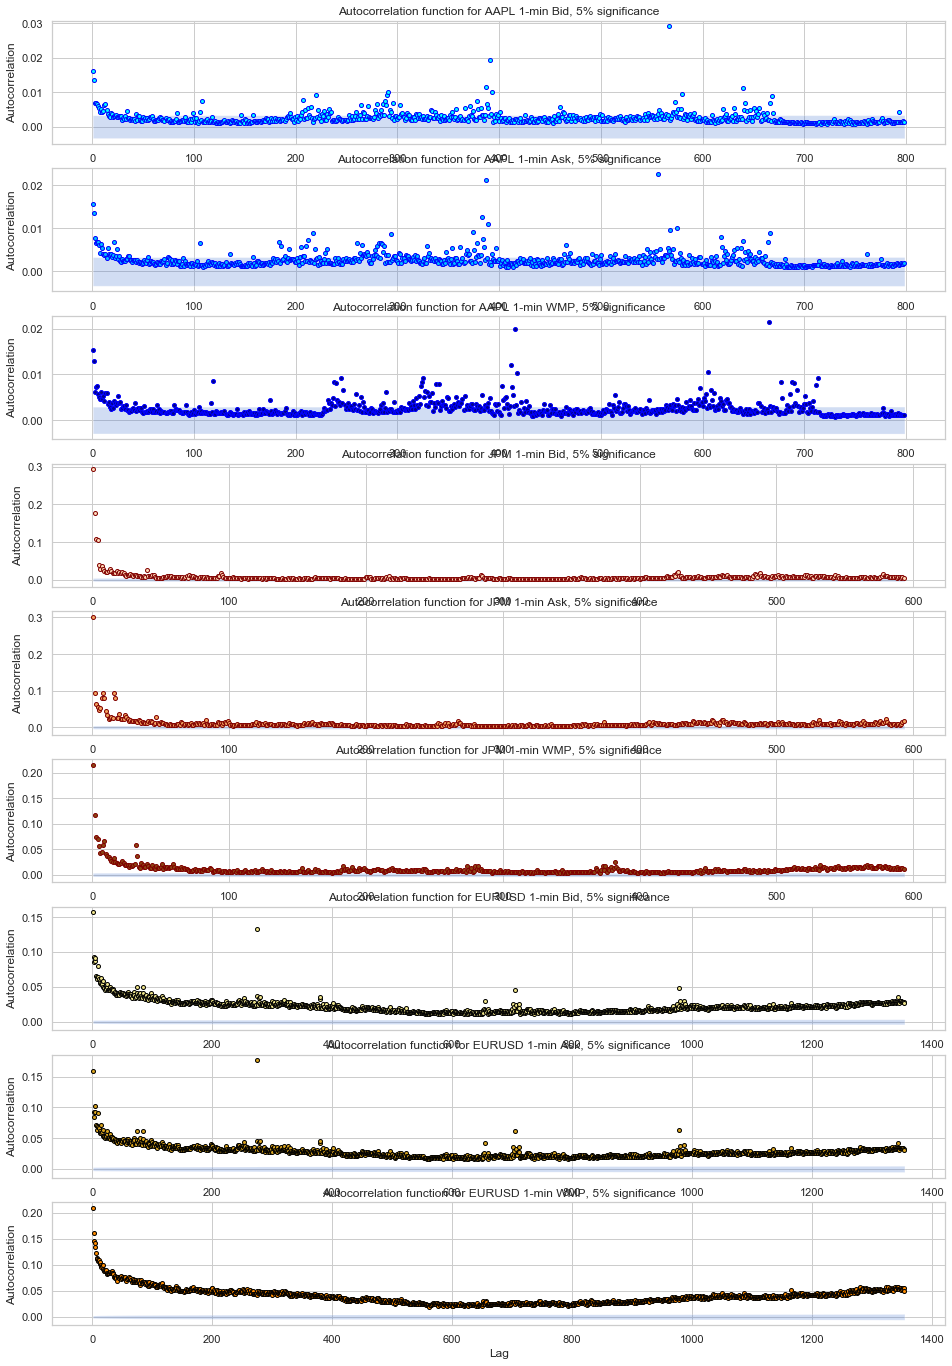

In [18]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

fig, ax = plt.subplots(9, figsize=(16,24));

sm.graphics.tsa.plot_acf(i, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='cyan', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(j, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[1], marker='o', markerfacecolor='deepskyblue', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(k, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[2], marker='o', markerfacecolor='darkblue', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(m, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[3], marker='o', markerfacecolor='peachpuff', markeredgecolor='maroon', markersize=4);
sm.graphics.tsa.plot_acf(n, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[4], marker='o', markerfacecolor='sandybrown', markeredgecolor='maroon', markersize=4);
sm.graphics.tsa.plot_acf(p, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[5], marker='o', markerfacecolor='saddlebrown', markeredgecolor='maroon', markersize=4);   
sm.graphics.tsa.plot_acf(q, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[6], marker='o', markerfacecolor='khaki', markeredgecolor='black', markersize=4);
sm.graphics.tsa.plot_acf(r, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[7], marker='o', markerfacecolor='goldenrod', markeredgecolor='black', markersize=4);
sm.graphics.tsa.plot_acf(s, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[8], marker='o', markerfacecolor='darkorange', markeredgecolor='black', markersize=4);

ax[0].set(title="Autocorrelation function for AAPL 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelation function for AAPL 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelation function for AAPL 1-min WMP, 5% significance", ylabel="Autocorrelation");
ax[3].set(title="Autocorrelation function for JPM 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[4].set(title="Autocorrelation function for JPM 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[5].set(title="Autocorrelation function for JPM 1-min WMP, 5% significance", ylabel="Autocorrelation");
ax[6].set(title="Autocorrelation function for EURUSD 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[7].set(title="Autocorrelation function for EURUSD 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[8].set(title="Autocorrelation function for EURUSD 1-min WMP, 5% significance", xlabel="Lag", ylabel="Autocorrelation");

plt.show();

## Autocorrelations

In [19]:
n_lags_a = 798      # 1 day, NB | i.shape = 353545, j.shape = 349845, k.shape = 449398
n_lags_j = 593      # 1 day, NB | m.shape = 264334, n.shape = 257702, p.shape = 334048
n_lags_fx = 1354    # 1 day, NB | q.shape = 762381, r.shape = 762381, s.shape = 762381

In [20]:
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np

# Autocorrelation computation using numpy.corrcoef
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

i_corr = autocorr(s, 60)

i_corr
# print("Autocorrelation function for AAPL 1-min Bid = ","\n", autocorr(i,i.shape))

array([[1.        , 0.07379596],
       [0.07379596, 1.        ]])

*Table X. Autocorrelations for AAPL, JPM, EURUSD 1-min Bid, Ask, and Weighted Mid-Prices with 60 (i.e. ~1 hour equivalent) and 798, 593, and 1354 (i.e. ~1 day equivalent) lags respectively*

| | Bid | Ask | WMP |
| --- | --- | --- | --- |
| **1 hour (60 lags)** |  |
| Equities AAPL HF (1-min returns) | 0.0024242 | 0.00269481 | 0.00048721 |
| Equities JPM HF (1-min returns) | -0.00102395 | -0.00198531 | -0.00090568 |
| FX EURUSD HF (1-min returns) | 0.00236498 | 0.00226641 | 0.00262666 |
| **1 day (798, 593, 1354 lags) respectively** |  |
| Equities AAPL HF (1-min returns) | 0.00311272 | -0.00324153 | 0.00156785 |
| Equities JPM HF (1-min returns) | -0.00022127 | -0.00040657 | 0.00060687 |
| FX EURUSD HF (1-min returns) | -0.00037868 | -0.00026630 | -0.00026892 |


## LBQ stats and summary table

SOURCES: 
* ___[PRIMARY SOURCE](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2018/02/TasksP_02.html)___
* https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test
* https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
* https://tedboy.github.io/statsmodels_doc/doc/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html
* https://stats.stackexchange.com/questions/200267/interpreting-ljung-box-test-results-from-statsmodels-stats-diagnostic-acorr-lju
* https://bradzzz.gitbooks.io/ga-dsi-seattle/dsi/dsi_09_time_series/4.1-lesson/readme.html

> * LBQ plus Box-Pierce stats, just in case the latter is helpful <br>
> * Use log returns | above workings show that raw returns don't work in the comparison of bid, ask, and WMP
> * Use 10 lags because it won't fit in the table otherwise | **`MAY NEED TO JUSTIFY USE OF 10 LAGS`**
> * Don't bother with the daily returns because I can't compute a weighted mid-price(doh!)

In [44]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd

n_lags = 10

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(i, lags=n_lags)), index = ["AAPL Bid LBQ stat", "AAPL Bid p-value"], columns = range(1, 11))

c:\users\john\phd\predictvol\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


,1,2,3,4,5,6,7,8,9,10
AAPL Bid LBQ stat,7.049627e+02,7.285930e+02,7.308660e+02,7.318274e+02,7.473345e+02,7.479865e+02,7.552461e+02,7.565510e+02,7.872218e+02,7.874335e+02
AAPL Bid p-value,2.491994e-155,6.138130e-159,4.255234e-158,4.469482e-157,2.852430e-159,2.653513e-158,8.401141e-159,4.739819e-158,1.196510e-163,1.037358e-162


In [45]:
pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(j, lags=n_lags)), index = ["AAPL Ask LBQ stat", "AAPL Ask p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
AAPL Ask LBQ stat,6.658521e+02,7.085085e+02,7.094936e+02,7.103565e+02,7.303665e+02,7.307314e+02,7.318596e+02,7.351690e+02,7.421125e+02,7.437109e+02
AAPL Ask p-value,7.973641e-147,1.410390e-154,1.834205e-153,1.993927e-152,1.333024e-155,1.414144e-154,9.302540e-154,1.912258e-153,6.078739e-154,2.577446e-153


In [46]:
pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(k, lags=n_lags)), index = ["AAPL WMP LBQ stat", "AAPL WMP p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
AAPL WMP LBQ stat,1.049596e+03,1.105598e+03,1.106040e+03,1.106237e+03,1.135325e+03,1.139016e+03,1.140391e+03,1.142019e+03,1.165256e+03,1.165317e+03
AAPL WMP p-value,2.979973e-230,8.363879e-241,1.781422e-239,3.367873e-238,2.991649e-243,7.539947e-243,5.465279e-242,3.218898e-241,3.833712e-245,4.355679e-244


In [47]:
pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(m, lags=n_lags)), index = ["JPM Bid LBQ stat", "JPM Bid p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
JPM Bid LBQ stat,18154.191315,18156.881792,18269.035176,18270.251485,18333.368822,18335.050614,18351.987269,18351.995468,18352.348745,18358.899596
JPM Bid p-value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [48]:
pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(n, lags=n_lags)), index = ["JPM Ask LBQ stat", "JPM Ask p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
JPM Ask LBQ stat,15276.345389,15282.068549,15451.178767,15451.241727,15464.686374,15469.930525,15548.657639,15757.453695,15768.648669,15773.218324
JPM Ask p-value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(p, lags=n_lags)), index = ["JPM WMP LBQ stat", "JPM WMP p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
JPM WMP LBQ stat,21659.058329,21707.3257,21889.194378,21891.592944,21912.98746,21932.694237,21934.946464,21935.130253,21972.873555,21989.514373
JPM WMP p-value,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(q, lags=n_lags)), index = ["FX Bid LBQ stat", "FX Bid p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
FX Bid LBQ stat,5.899889e+02,6.170314e+02,6.542258e+02,6.545919e+02,7.087360e+02,7.104112e+02,7.130638e+02,7.231761e+02,7.255608e+02,7.345934e+02
FX Bid p-value,2.519557e-130,1.031167e-134,1.766641e-141,2.362851e-140,6.343149e-151,3.455825e-150,1.051652e-149,7.318351e-151,2.206898e-150,2.342496e-151


In [51]:
pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(r, lags=n_lags)), index = ["FX Ask LBQ stat", "FX Ask p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
FX Ask LBQ stat,4.544553e+02,4.590161e+02,4.773734e+02,4.828775e+02,5.601640e+02,5.605960e+02,5.689316e+02,5.816562e+02,5.828048e+02,5.828052e+02
FX Ask p-value,7.736046e-101,2.118016e-100,3.819122e-103,3.381313e-103,8.157404e-119,7.335523e-118,1.189596e-118,2.052088e-120,1.025339e-119,8.495767e-119


In [52]:
pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(s, lags=n_lags)), index = ["FX WMP LBQ stat", "FX WMP p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
FX WMP LBQ stat,8.723964,10.517112,10.517516,10.755117,13.190403,13.248132,13.248231,13.423052,21.616024,27.189627
FX WMP p-value,0.003141,0.005203,0.014643,0.029458,0.021658,0.039261,0.066286,0.098099,0.010179,0.002430


> **`THOUGHTS`**
> * 10 lags is enough for the Q-stat because we can see from the autocorrelogram (1 day, i.e. several hundred lags) that the autocorrelations are relatively stable. Thus, 10 is representative. Try to find support for this in the literature.

*Table [X]. Ljung-Box Q statistics for AAPL, JPM, and EURUSD HF log returns*

| | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **AAPL Bid** |  |  |  |  |  |  |  |
| LBQ stat | 7.049627e+02 | 7.285930e+02 | 7.308660e+02 | 7.318274e+02 | 7.473345e+02 | 7.479865e+02 | 7.552461e+02 | 7.565510e+02 | 7.872218e+02 | 7.874335e+02 |
| p-value | 2.491994e-155 | 6.138130e-159 | 4.255234e-158 | 4.469482e-157 | 2.852430e-159 | 2.653513e-158 | 8.401141e-159 | 4.739819e-158 | 1.196510e-163 | 1.037358e-162 |
| **AAPL Ask** |  |  |  |  |  |  |
| LBQ stat | 6.658521e+02 | 7.085085e+02 | 7.094936e+02 | 7.103565e+02 | 7.303665e+02 | 7.307314e+02 | 7.318596e+02 | 7.351690e+02 | 7.421125e+02 | 7.437109e+02 |
| p-value | 7.973641e-147 | 1.410390e-154 | 1.834205e-153 | 1.993927e-152 | 1.333024e-155 | 1.414144e-154 | 9.302540e-154 | 1.912258e-153 | 6.078739e-154 | 2.577446e-153 |
| **AAPL WMP** |  |  |  |  |  |  |
| LBQ stat | 1.049596e+03 | 1.105598e+03 | 1.106040e+03 | 1.106237e+03 | 1.135325e+03 | 1.139016e+03 | 1.140391e+03 | 1.142019e+03 | 1.165256e+03 | 1.165317e+03 |
| p-value | 2.979973e-230 | 8.363879e-241 | 1.781422e-239 | 3.367873e-238 | 2.991649e-243 | 7.539947e-243 | 5.465279e-242 | 3.218898e-241 | 3.833712e-245 | 4.355679e-244 |
| **JPM Bid** |  |  |  |  |  |  |
| LBQ stat | 18154.191315 | 18156.881792 | 18269.035176 | 18270.251485 | 18333.368822 | 18335.050614 | 18351.987269 | 18351.995468 | 18352.348745 | 18358.899596 |
| p-value | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 |
| **JPM Ask** |  |  |  |  |  |  |
| LBQ stat | 15276.345389 | 15282.068549 | 15451.178767 | 15451.241727 | 15464.686374 | 15469.930525 | 15548.657639 | 15757.453695 | 15768.648669 | 15773.218324 |
| p-value | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 |
| **JPM WMP** |  |  |  |  |  |  |
| LBQ stat | 21659.058329 | 21707.3257 | 21889.194378 | 21891.592944 | 21912.98746 | 21932.694237 | 21934.946464 | 21935.130253 | 21972.873555 | 21989.514373 |
| p-value | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 | 0.000000 |
| **FX HF Bid** |  |  |  |  |  |  |
| LBQ stat | 5.899889e+02 | 6.170314e+02 | 6.542258e+02 | 6.545919e+02 | 7.087360e+02 | 7.104112e+02 | 7.130638e+02 | 7.231761e+02 | 7.255608e+02 | 7.345934e+02 |
| p-value | 2.519557e-130 | 1.031167e-134 | 1.766641e-141 | 2.362851e-140 | 6.343149e-151 | 3.455825e-150 | 1.051652e-149 | 7.318351e-151 | 2.206898e-150 | 2.342496e-151 |
| **FX HF Ask** |  |  |  |  |  |  |
| LBQ stat | 4.544553e+02 | 4.590161e+02 | 4.773734e+02 | 4.828775e+02 | 5.601640e+02 | 5.605960e+02 | 5.689316e+02 | 5.816562e+02 | 5.828048e+02 | 5.828052e+02 |
| p-value | 7.736046e-101 | 2.118016e-100 | 3.819122e-103 | 3.381313e-103 | 8.157404e-119 | 7.335523e-118 | 1.189596e-118 | 2.052088e-120 | 1.025339e-119 | 8.495767e-119 |
| **FX HF WMP** |  |  |  |  |  |  |
| LBQ stat | 4.874529e+02 | 5.238278e+02 | 5.628675e+02 | 5.683507e+02 | 6.201679e+02 | 6.234929e+02 | 6.243620e+02 | 6.305818e+02 | 6.313944e+02 | 6.371490e+02 |
| p-value | 5.105491e-108 | 1.787511e-114 | 1.129243e-121 | 1.094770e-121 | 8.870179e-132 | 1.993443e-131 | 1.378557e-130 | 6.209114e-131 | 3.811356e-130 | 1.918503e-130 |

**COMMENTARY RE LBQ-STATS AND P-VALUES** <br>
_[scroll to bottom for this](https://stats.stackexchange.com/questions/200267/interpreting-ljung-box-test-results-from-statsmodels-stats-diagnostic-acorr-lju)_ <br>
* Ljung-Box is a test on the cumulative sum of autocorrelations, so it's different from just looking at individual autocorrelation in the plots. E.g. there could be many individually insignificant autocorrelation coefficients but they are all positive so they add up
* We reject the null of no autocorrelation if the p-value is small. You didn't specify how many observations you have. I would interpret your results as that in your data there is no autocorrelation for the first 10 or a bit more lags. For larger lags, the tests reject the no autocorrelation hypothesis, but my guess is that it's more likely that something else is going on, biased hypothesis test, sample size too small, violation of an assumption or similar

## Time series analytics

> * OBJECTIVE | use the time series analytics for each dataset to explain certain aspects of the results <br>
> * SOURCE | _[Buteikis](http://web.vu.lt/mif/a.buteikis/wp-content/uploads/2018/02/TasksP_02.html)_ 

In [21]:
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

k = smF.loc[smF['Ticker'] == "AAPL"]
k = np.log(k['WeightedMidPrice'].astype(float))
k = k - k.shift(1)
k = k[k.notna()].copy()
k = k[k != 0].copy()

p = smF.loc[smF['Ticker'] == "JPM"]
p = np.log(p['WeightedMidPrice'].astype(float))
p = p - p.shift(1)
p = p[p.notna()].copy()
p = p[p != 0].copy()

q = lrFX

k.shape, p.shape, q.shape

((449398,), (334048,), (762381,))

In [22]:
from scipy import stats
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", palette="muted")

def tsdisplay(y, figsize = (16,9), title = "", color = ""):
    tmp_data = pd.Series(y)
    
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Log\ returns\ time\ series:\ " + title + "$", legend = False, color=color, linewidth=0.5, alpha=0.75)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(323))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = 20, zero = False, color=color, ax = fig.add_subplot(324))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', color=color, ax = fig.add_subplot(325)) 
    plt.title("Q-Q Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, color=color, bins = 120)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()

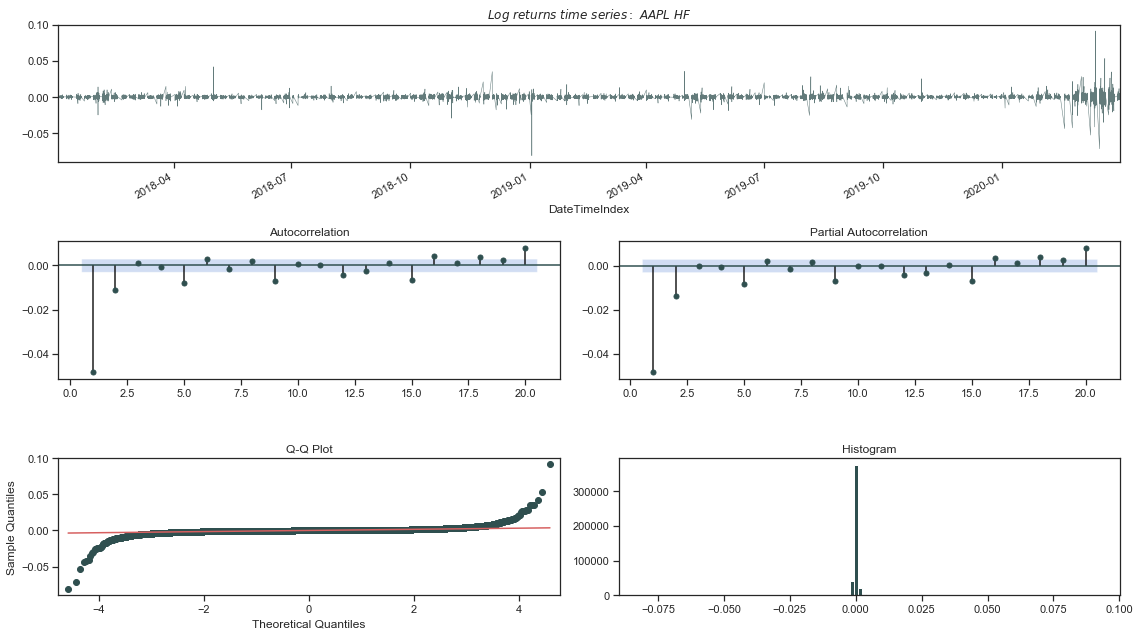

In [23]:
tsdisplay(k, title = "AAPL\ HF", color='darkslategrey')

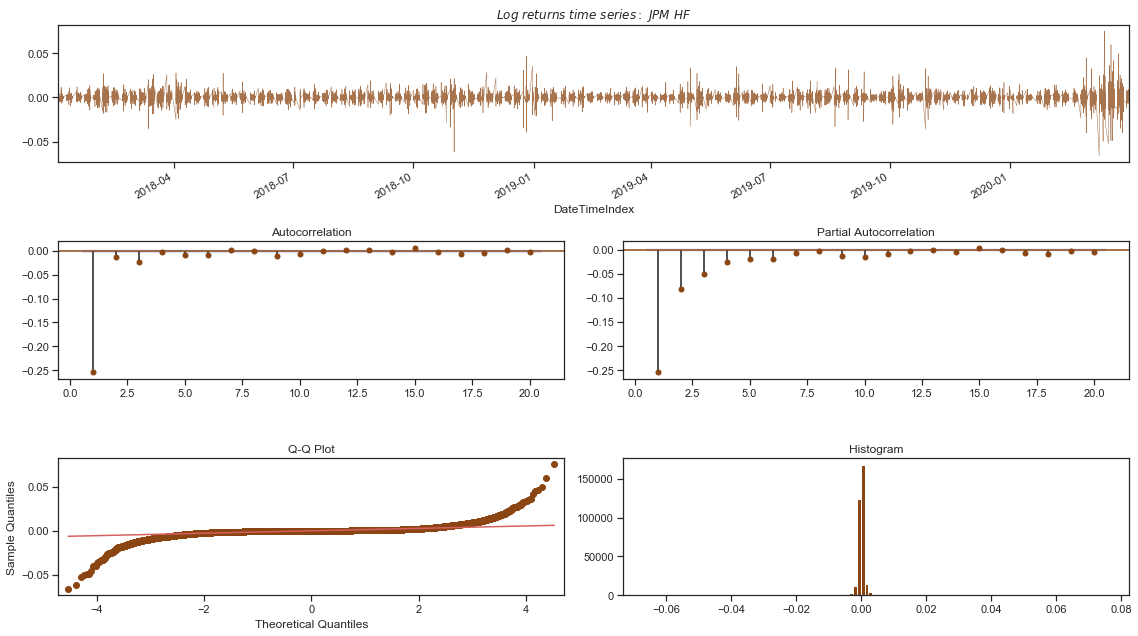

In [24]:
tsdisplay(p, title = "JPM\ HF", color='saddlebrown')

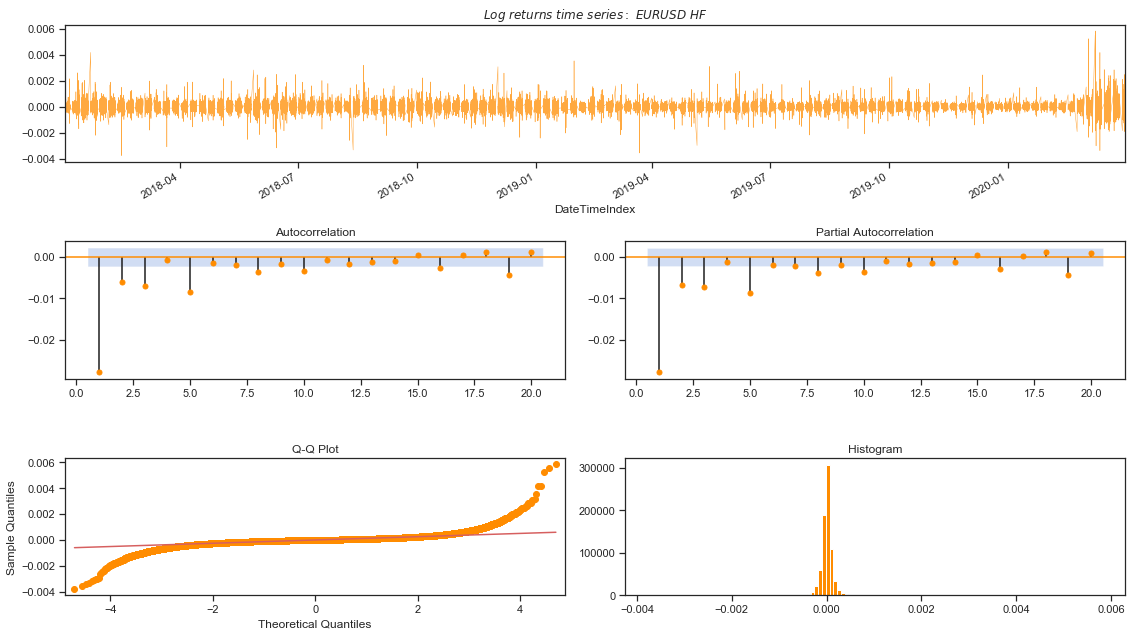

In [25]:
tsdisplay(q, title = "EURUSD\ HF", color='darkorange')

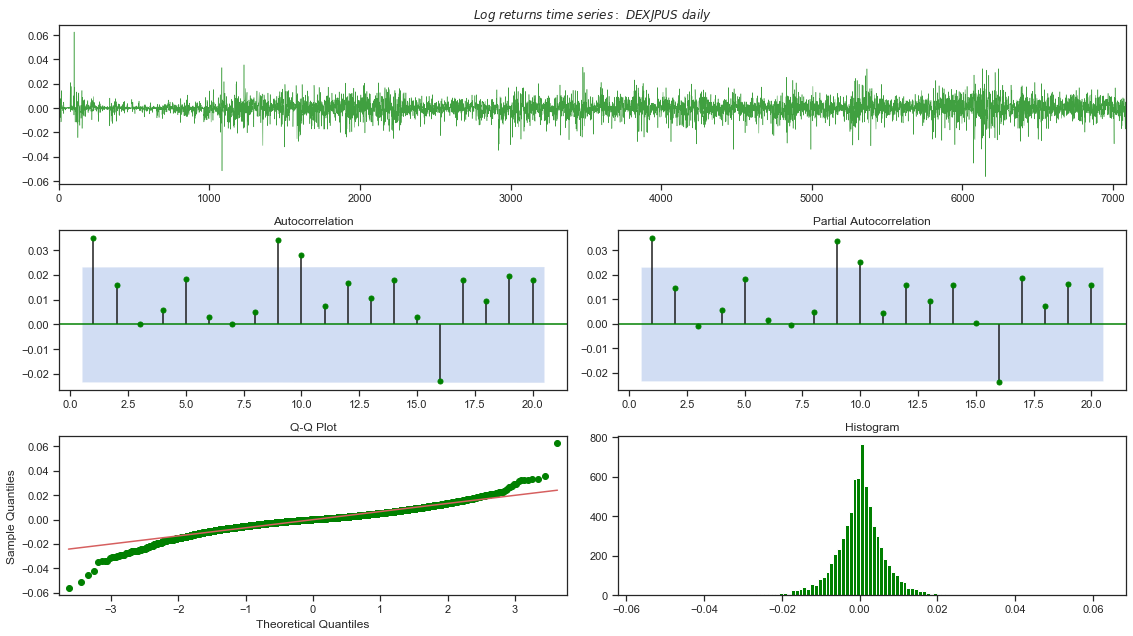

In [26]:
s = np.array(dat2).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "DEXJPUS\ daily", color='green')

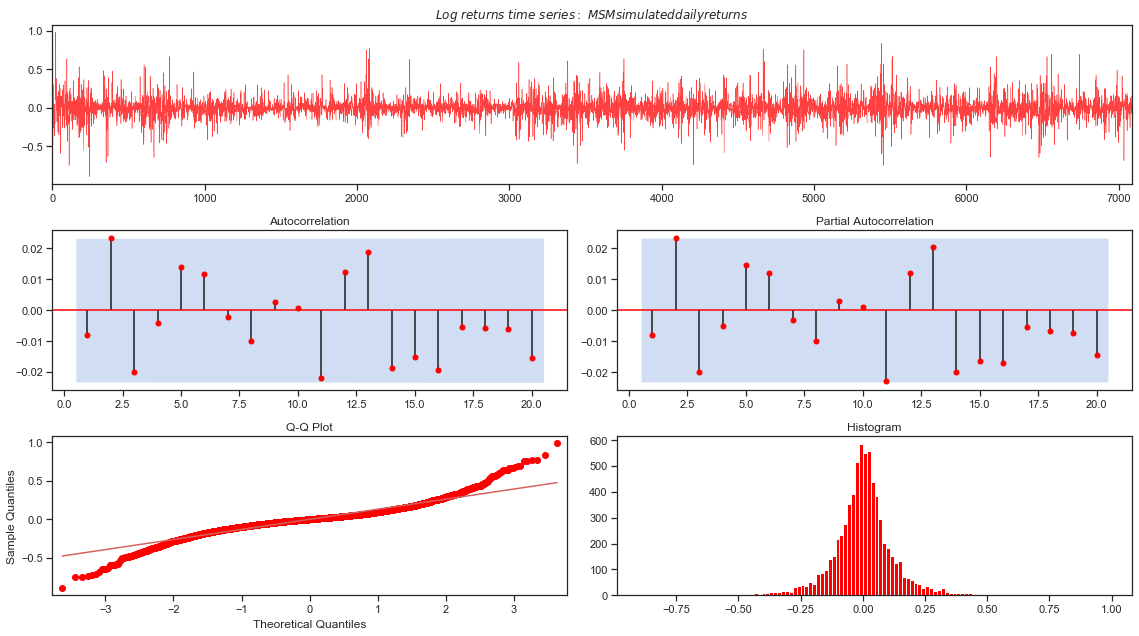

In [27]:
s = np.array(dat1).astype(float)
s = s[s != 0].copy()
tsdisplay(s, title = "MSM simulated daily returns", color='red')

## LBQ workings

***
> **START** | COMPARE LOG RETURNS TO RAW RETURNS <br>

> **THOUGHTS/OBSERVATIONS**
>> * Logs versus raw returns definitely makes a difference, especially when looking at the whole dataset.  **`What does the literature do?`**
>> * Using whole dataset versus 1-day really makes a difference!! (Much bigger difference than logs versus raw returns). **`WHY??`**

*LOG RETURNS*

In [28]:
import statsmodels.api as sm
import pandas as pd

# LOOK AT THE WHOLE DATASET
AAPL_lr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
AAPL_lr = AAPL_lr['2019-03-31 00:00:01':'2020-03-31 23:59:59']

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_lr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,8179.972923,8212.632485,8263.894637,8283.170039,8289.173311,8333.843113,8342.147591,8353.478054,8424.771944,8431.508686
p-value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
# LOOK AT THE LAST DAY
AAPL_lr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
AAPL_lr = AAPL_lr['2020-03-31 00:00:01':'2020-03-31 23:59:59']

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_lr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,2.953875e+01,3.149879e+01,3.173725e+01,33.257069,3.694846e+01,3.873107e+01,38.858229,4.452668e+01,4.649594e+01,5.033409e+01
p-value,5.480995e-08,1.445856e-07,5.945089e-07,0.000001,6.133660e-07,8.080953e-07,0.000002,4.523654e-07,4.870904e-07,2.316803e-07


In [17]:
# LOOK AT THE LAST 20 RECORDS
AAPL_lr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
AAPL_lr = AAPL_lr[-20:,]

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_lr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,0.329866,1.663222,2.120661,2.283084,6.577876,8.312767,9.211323,10.132886,10.391933,10.641564
p-value,0.565738,0.435347,0.547744,0.683851,0.253974,0.216073,0.237838,0.255823,0.319697,0.386116


*RAW RETURNS*

In [18]:
import statsmodels.api as sm
import pandas as pd

# LOOK AT THE WHOLE DATASET
AAPL_rr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_rr = AAPL_rr['WeightedMidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_rr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,24891.230439,24908.817934,25088.505023,25103.073113,25117.119898,25136.268484,25136.660472,25136.812986,25158.655094,25173.983648
p-value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
# LOOK AT THE LAST DAY
AAPL_rr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_rr = AAPL_rr['WeightedMidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()
AAPL_rr = AAPL_rr['2020-03-31 00:00:01':'2020-03-31 23:59:59']

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_rr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,2.947337e+01,3.170199e+01,3.198761e+01,3.344331e+01,3.710461e+01,3.907192e+01,39.187158,4.485842e+01,4.662743e+01,5.032679e+01
p-value,5.669039e-08,1.306171e-07,5.265019e-07,9.691315e-07,5.707098e-07,6.928972e-07,0.000002,3.914482e-07,4.604202e-07,2.323981e-07


In [20]:
# LOOK AT THE LAST 20 RECORDS
AAPL_rr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_rr = AAPL_rr['WeightedMidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()
AAPL_rr = AAPL_rr[-20:,]

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_rr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,0.325728,1.666521,2.123953,2.287474,6.583665,8.311899,9.214318,10.133035,10.389941,10.638751
p-value,0.568186,0.434630,0.547082,0.683051,0.253490,0.216132,0.237633,0.255813,0.319849,0.386346


> **END** | COMPARE LOG RETURNS TO RAW RETURNS
***

***
> **START** | COMPARE BID, ASK, WEIGHTED MID PRICES <br>

> **THOUGHTS/OBSERVATIONS**
>> * Should I call the test statistic `Q-stat` or `Ljung-Box statistic`??
>> * Clearly, I need to use log returns, because Bid and Ask don't work with raw returns!! Would be helpful to understand why??

*LOG RETURNS*

In [21]:
import statsmodels.api as sm
import pandas as pd

# CloseBidPrice
AAPL_lr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_lr = np.log(AAPL_lr['CloseBidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_lr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,18154.191315,18156.881792,18269.035176,18270.251485,18333.368822,18335.050614,18351.987269,18351.995468,18352.348745,18358.899596
p-value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
# CloseAskPrice
AAPL_lr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_lr = np.log(AAPL_lr['CloseAskPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_lr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,15276.345389,15282.068549,15451.178767,15451.241727,15464.686374,15469.930525,15548.657639,15757.453695,15768.648669,15773.218324
p-value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [23]:
# WeightedMidPrice
AAPL_lr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_lr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,21659.058329,21707.3257,21889.194378,21891.592944,21912.98746,21932.694237,21934.946464,21935.130253,21972.873555,21989.514373
p-value,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


*RAW RETURNS*

In [24]:
import statsmodels.api as sm
import pandas as pd

# CloseBidPrice
AAPL_rr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_rr = AAPL_rr['CloseBidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_rr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,424767.61229,840593.483588,1.243137e+06,1.633837e+06,2.014709e+06,2.386385e+06,2.749982e+06,3.106389e+06,3.454644e+06,3.796888e+06
p-value,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [25]:
# CloseAskPrice
AAPL_rr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_rr = AAPL_rr['CloseAskPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_rr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,436209.76698,860635.198784,1.270190e+06,1.667221e+06,2052534.842,2.427418e+06,2.792648e+06,3.150770e+06,3.499090e+06,3.841620e+06
p-value,0.00000,0.000000,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [26]:
# WeightedMidPrice
AAPL_rr = smF.loc[smF['Ticker'] == "JPM"]
AAPL_rr = AAPL_rr['WeightedMidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()

pd.DataFrame(list(sm.stats.diagnostic.acorr_ljungbox(AAPL_rr, lags = 10)), index = ["LBQ-stat", "p-value"], columns = range(1, 11))

,1,2,3,4,5,6,7,8,9,10
LBQ-stat,24891.230439,24908.817934,25088.505023,25103.073113,25117.119898,25136.268484,25136.660472,25136.812986,25158.655094,25173.983648
p-value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


> **END** | COMPARE BID, ASK, WEIGHTED MID PRICES <br>
***

## Variance Ratio statistics

* Data for the Variance Ratio statistics = log returns

> See this _[quant stackexchange](https://quant.stackexchange.com/questions/19366/when-measuring-autocorrelation-should-you-use-log-returns-or-prices)_

* All of the work in this section follows _[Sheppard (2019), Unit Root Testing](https://arch.readthedocs.io/en/latest/unitroot/unitroot.html)_, unless specifically stated otherwise (i.e., work below that follows _[Mingze-Gao](https://mingze-gao.com/measures/lomackinlay1988/)_

### Setup

From | https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html

* I define one of the three time series as `default`, to simplify the workflow below

In [5]:
# default = AAPL_lr
default = JPM_lr
# default = lr_FX

# lags = n_lags_a = 798      # 1 day
lags = n_lags_j = 593      # 1 day
# lags = n_lags_fx = 1354    # 1 day

AAPL_lr.shape, JPM_lr.shape, lrFX.shape

((449363,), (333939,), (762381,))

* I convert default to a pandas dataframe for tractability

In [6]:
default = pd.DataFrame(default)
default.head()

,WeightedMidPrice
DateTimeIndex,
2018-01-02 04:39:00,-0.006747
2018-01-02 04:47:00,0.003098
2018-01-02 05:43:00,-0.003098
2018-01-02 05:45:00,0.003140
2018-01-02 06:11:00,-0.002118


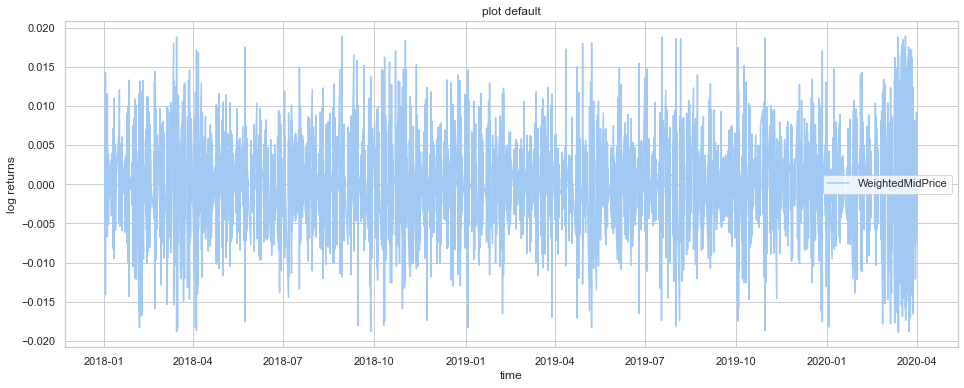

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set(rc={'figure.figsize':(16,6)})
sns.set_style("whitegrid")

sns.lineplot(data=default, palette="pastel");
plt.title('plot default');
plt.ylabel('log returns');
plt.xlabel('time');
plt.legend(loc = 7);

### Re-visiting autocorrelations

* Are the autocorrelations below identical to mine above.  At first glance yes.  What is this telling me?

<Figure size 1152x432 with 0 Axes>

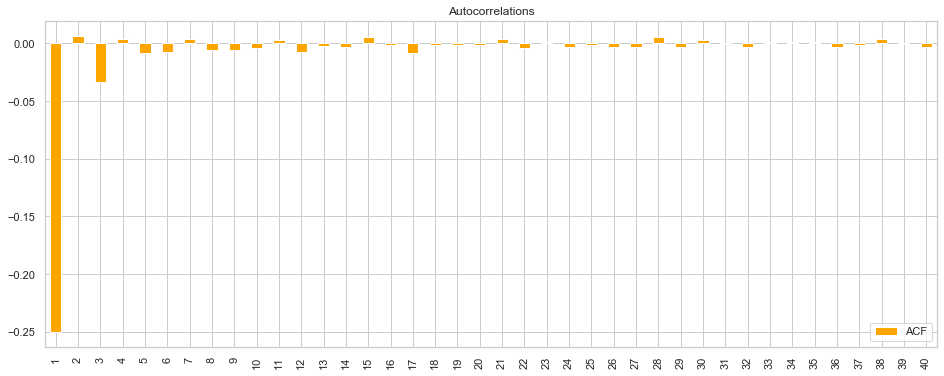

In [9]:
import statsmodels.api as sm
sns.set(rc={'figure.figsize':(16,6)})
sns.set_style("whitegrid")

fig = plt.figure(figsize=(16,6));  
acf = pd.DataFrame(sm.tsa.stattools.acf(default, lags, fft=False), columns=["ACF"]);
fig = acf[1:].plot(kind="bar", title="Autocorrelations", color = 'orange');

## VR tests.ipynb

* The variance ratio compares the variance of a 1-period return to that of a multi-period return. The comparison length has to be set when initializing the test.

* I do this by defining `lags` and using the `default` time series, which is usually `JPM`

### The variance ratio

In [9]:
from arch.unitroot import VarianceRatio

vr_1min = VarianceRatio(default, 60).vr
vr_lags = VarianceRatio(default, lags).vr


print("VarianceRatio.vr, being the ratio of the long block lags-period variance to the 1-period variance: ","\n"
      "60 lags or 1-min = ", vr_1min, "\n"
      "the variable lags, usually 1 day = ", vr_lags
      ) 

VarianceRatio.vr, being the ratio of the long block lags-period variance to the 1-period variance:  
60 lags or 1-min =  0.013356220238881502 
the variable lags, usually 1 day =  0.0013558792336283766


### The VR test and p-value

In [10]:
from arch.unitroot import VarianceRatio

vr = VarianceRatio(default, lags)
print(vr.summary().as_text())

     Variance-Ratio Test Results     
Test Statistic                -25.221
P-value                         0.000
Lags                              593
-------------------------------------

Computed with overlapping blocks (de-biased)


* Comment from _[Sheppard (2019)](https://arch.readthedocs.io/en/latest/unitroot/unitroot_examples.html)_ | The null that the series is a pure random walk is rejected. Negative values indicate some positive autocorrelation in the returns (momentum).

* Sheppard's comment, based upon his example, appears to be consistent with what I observe

### Compute variance ratios for AAPL, JPM, and EURUSD

* **Again following Sheppard (2019), _[Variance Ratio parameters documentation here](https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.VarianceRatio.html)_**

In [11]:
# obtain test statistics for each time series (i.e., for AAPL, JPM, and EURUSD)
# See | https://arch.readthedocs.io/en/latest/unitroot/generated/arch.unitroot.VarianceRatio.html

n_lags_a = 798      # 1 day
n_lags_j = 593      # 1 day
n_lags_fx = 1354    # 1 day, NB | use this value for all 3 VR stat plots, to get common x-axis

a = VarianceRatio(AAPL_lr, n_lags_a).vr
j = VarianceRatio(JPM_lr, n_lags_j).vr
fx = VarianceRatio(lrFX, n_lags_fx).vr

print("Variance Ratio for AAPL = ", a, "\n"
      "Variance Ratio for JPM = ", j, "\n"
      "Variance Ratio for EURUSD = ", fx
      )

Variance Ratio for AAPL =  0.001194983176557182 
Variance Ratio for JPM =  0.0013558792336283766 
Variance Ratio for EURUSD =  0.0007185717337455734


### Simple returns (i.e., not WMP)

**Compute `simple` (i.e., not WMP) returns**

In [28]:
# Simple returns
# AAPL_lr_simple = smF.loc[smF['Ticker'] == "AAPL"]
# AAPL_lr_simple = np.log(AAPL_lr_simple['CloseAskPrice'].astype(float))
# AAPL_lr_simple = AAPL_lr_simple - AAPL_lr_simple.shift(1)
# AAPL_lr_simple = AAPL_lr_simple[AAPL_lr_simple.notna()].copy()
# AAPL_lr_simple = AAPL_lr_simple[AAPL_lr_simple != 0].copy()

# JPM_lr_simple = smF.loc[smF['Ticker'] == "JPM"]
# JPM_lr_simple = np.log(JPM_lr_simple['CloseAskPrice'].astype(float))
# JPM_lr_simple = JPM_lr_simple - JPM_lr_simple.shift(1)
# JPM_lr_simple = JPM_lr_simple[JPM_lr_simple.notna()].copy()
# JPM_lr_simple = JPM_lr_simple[JPM_lr_simple != 0].copy()

# simple datasets for equities based on OpenBidPrice from bigF dataframe
AAPL_lr_simple_OB = bigF.loc[bigF['Ticker'] == "AAPL"]
AAPL_lr_simple_OB = np.log(AAPL_lr_simple_OB['HighAskPrice'].astype(float))
AAPL_lr_simple_OB = AAPL_lr_simple_OB - AAPL_lr_simple_OB.shift(1)
AAPL_lr_simple_OB = AAPL_lr_simple_OB[AAPL_lr_simple_OB.notna()].copy()
AAPL_lr_simple_OB = AAPL_lr_simple_OB[AAPL_lr_simple_OB != 0].copy()

JPM_lr_simple_OB = bigF.loc[bigF['Ticker'] == "JPM"]
JPM_lr_simple_OB = np.log(JPM_lr_simple_OB['HighAskPrice'].astype(float))
JPM_lr_simple_OB = JPM_lr_simple_OB - JPM_lr_simple_OB.shift(1)
JPM_lr_simple_OB = JPM_lr_simple_OB[JPM_lr_simple_OB.notna()].copy()
JPM_lr_simple_OB = JPM_lr_simple_OB[JPM_lr_simple_OB != 0].copy()

# simple dataset for FX based on barHighBid
lrFX_simple = np.log(dfFX['barHighBid'].astype(float))
lrFX_simple = lrFX_simple - lrFX_simple.shift(1)
lrFX_simple = lrFX_simple[lrFX_simple.notna()].copy()
lrFX_simple = lrFX_simple[lrFX_simple != 0].copy()

AAPL_lr_simple_OB.shape, JPM_lr_simple_OB.shape, lrFX_simple.shape

((319346,), (242206,), (748780,))

**Visualize, just to check look ok**

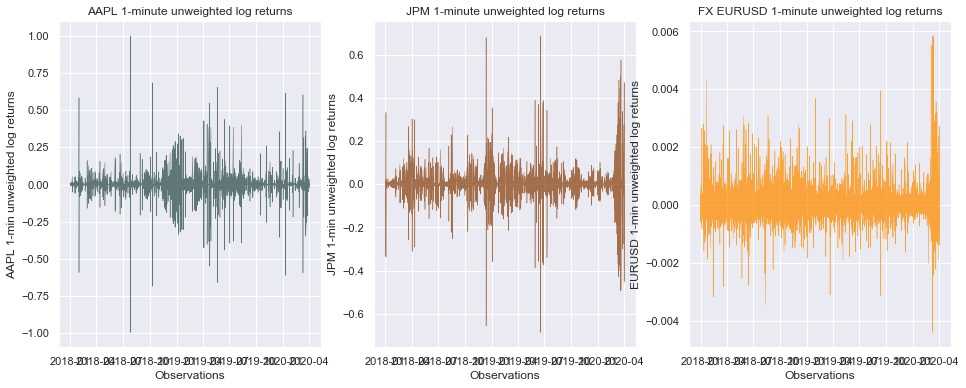

In [29]:
from scipy import stats
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(16,6))  

ax1 = plt.subplot(131)
ax1.set(title="AAPL 1-minute unweighted log returns", xlabel="Observations", ylabel="AAPL 1-min unweighted log returns");
ax1.plot(AAPL_lr_simple_OB, color='darkslategrey', linewidth=0.5, alpha=0.75)

ax2 = plt.subplot(132)
ax2.set(title="JPM 1-minute unweighted log returns", xlabel="Observations", ylabel="JPM 1-min unweighted log returns") 
ax2.plot(JPM_lr_simple_OB, color='saddlebrown', linewidth=0.5, alpha=0.75)

ax3 = plt.subplot(133)
ax3.set(title="FX EURUSD 1-minute unweighted log returns", xlabel="Observations", ylabel="EURUSD 1-min unweighted log returns") 
ax3.plot(lrFX_simple, color='darkorange', linewidth=0.5, alpha=0.75)

plt.show();

**Create three seperate charts**

In [46]:
vr_a = []
vr_j = []
vr_fx = []
vr_a_simple = []
vr_j_simple = []
vr_fx_simple = []

i_start = 60       # start at 60 to remove higher frequencies

# write vr into 3 separate lists
# for i in range (i_start, n_lags_fx):
    # vr_a.append(VarianceRatio(AAPL_lr, i).vr)     # note that I set debiased = False
    # vr_j.append(VarianceRatio(JPM_lr, i).vr)
    # vr_fx.append(VarianceRatio(lrFX, i).vr)
    # simple
    # vr_a_simple.append(VarianceRatio(AAPL_lr_simple, i).vr)
    # vr_j_simple.append(VarianceRatio(JPM_lr_simple, i).vr)
    # vr_fx_simple.append(VarianceRatio(lrFX_simple, i).vr)
    
# write vr into 3 separate lists for OB data subsets
for i in range (i_start, n_lags_fx):
    vr_a.append(VarianceRatio(AAPL_lr, i).vr)     
    vr_j.append(VarianceRatio(JPM_lr, i).vr)
    vr_fx.append(VarianceRatio(lrFX, i).vr)
    # simple based on OB datasets
    vr_a_simple.append(VarianceRatio(AAPL_lr_simple_OB, i).vr)
    vr_j_simple.append(VarianceRatio(JPM_lr_simple_OB, i).vr)
    vr_fx_simple.append(VarianceRatio(lrFX_simple, i).vr)

# put AAPL, JPM, and FX lists into three dataframes | Note that I have swapped simple and WMP for both AAPL and JPM
vr_list_a = pd.DataFrame(np.column_stack([vr_a_simple, vr_a]), 
                               columns=['AAPL-WMP', 'AAPL-simple'])

vr_list_j = pd.DataFrame(np.column_stack([vr_j_simple, vr_j]), 
                               columns=['JPM-WMP', 'JPM-simple'])

vr_list_fx = pd.DataFrame(np.column_stack([vr_fx, vr_fx_simple]), 
                               columns=['EURUSD-WMP', 'EURUSD-simple'])

vr_list_a.head(), vr_list_j.head(), vr_list_fx.head()

(   AAPL-WMP  AAPL-simple
 0  0.011169     0.015799
 1  0.010978     0.015519
 2  0.010806     0.015340
 3  0.010640     0.015078
 4  0.010471     0.014851,     JPM-WMP  JPM-simple
 0  0.011134    0.013356
 1  0.010973    0.013027
 2  0.010769    0.012927
 3  0.010627    0.012715
 4  0.010439    0.012508,    EURUSD-WMP  EURUSD-simple
 0    0.016178       0.018624
 1    0.015966       0.018403
 2    0.015719       0.018151
 3    0.015445       0.017833
 4    0.015238       0.017580)

### Write-up

I compute Variance Ratios following Lo & Mackinlay (1988) and Campbell, Lo & MacKinlay (1997).  The Variance Ratio, $\mathrm{VR}$, of a $q$-period $\mathrm{WMP}$ returns series may be defined thus:
$\\[0.1in]$

\begin{equation}
    \mathrm{VR} \left( q \right) = \frac {\mathrm{Var} \left( \mathrm{WMP}_t, + \mathrm{WMP}_{t+1}, + ... + \mathrm{WMP}_{t-q+1} \right) / \, q} {\mathrm{Var} \left( \mathrm{WMP}_t \right)}
\end{equation}

$\\[0.1in]$
Lo & Mackinlay write the estimator for $\mathrm{VR} \left( q \right)$ thus:
$\\[0.1in]$

\begin{equation}
    \mathrm{VR} \left( q \right) = \frac {\hat \sigma^2 \left( q \right)} {\hat \sigma^2 \left( 1 \right)}
\end{equation}

$\\[0.1in]$
Where $\hat \sigma ^2 \left( 1 \right)$ is an unbiased estimator of 1-period returns thus: 
$\\[0.1in]$

\begin{equation}
    \hat \sigma ^2 \left( 1 \right) = \frac {1} {\mathrm{T} - 1} \sum^T_{t-1} \left( \mathrm{WMP}_t - \hat \mu \right) ^2
\end{equation}

$\\[0.1in]$
And where $\hat \sigma ^2 \left( q \right)$ is the estimator of the variance of the q-period returns, thus: 
$\\[0.1in]$

\begin{equation}
    \hat \sigma ^2 \left( q \right) = \frac {1} {m} \sum^T_{t-1} \left( \mathrm{ln} \frac {\mathrm{WMP}_t} {\mathrm{WMP}_{t-q}} - q \hat \mu \right) ^2
\end{equation}

$\\[0.1in]$
Each $\mathrm{VR}$ may therefore be thought of as the ratio of the $q$-times overlapping $\mathrm{WMP}$ return period versus the variance of the $\mathrm{WMP}$ return series multiplied by $q$.  These ratios are asymptotically equal to one for a random walk, less than one for a mean reverting series, and greater than one for a mean-averting series.
$\\[0.1in]$

$\\[0.1in]$
Figure 12 shows Variance Ratio plots for AAPL, JPM, EURUSD Weighted Mid-Price returns and Unweighted Mid-Price returns, comparing the range of frequencies, $q$, from 1 minute to 1 day:
$\\[0.1in]$

*Figure 12. Variance Ratio plots for AAPL, JPM, EURUSD Weighted Mid-Price returns and Unweighted Mid-Price returns, comparing the range of frequencies, $q$, from 1 minute to 1 day*

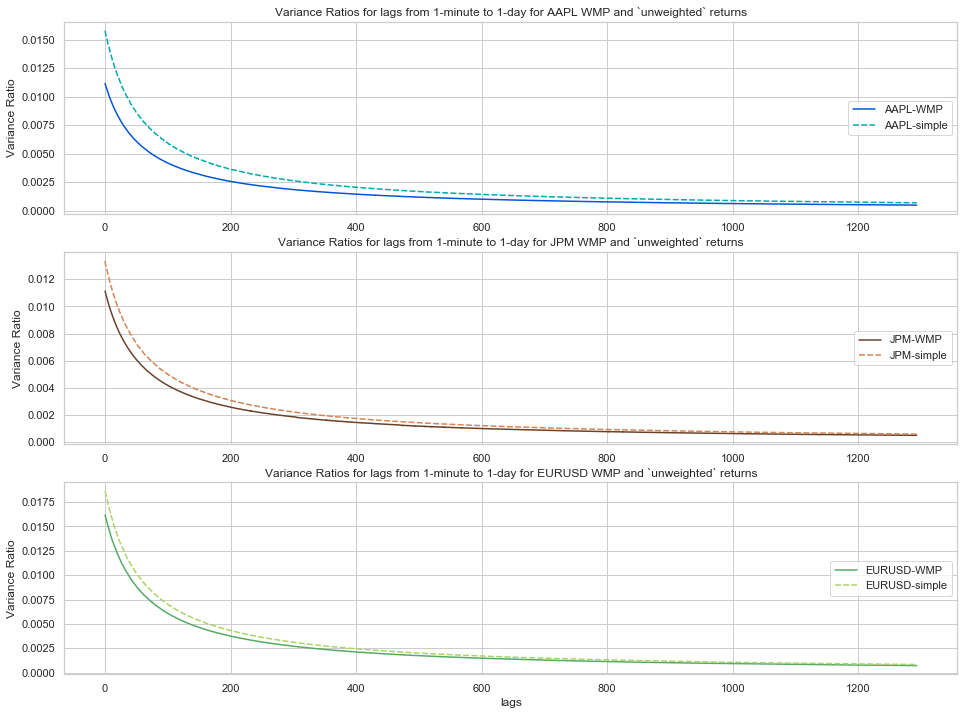

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("whitegrid")

ax1 = plt.subplot(311);
ax1 = sns.lineplot(data=vr_list_a, palette="winter");
ax1.set(title="Variance Ratios for lags from 1-minute to 1-day for AAPL WMP and `unweighted` returns", ylabel="Variance Ratio");
ax1.legend(loc=7);

ax2 = plt.subplot(312);
ax2 = sns.lineplot(data=vr_list_j, palette="copper");
ax2.set(title="Variance Ratios for lags from 1-minute to 1-day for JPM WMP and `unweighted` returns", ylabel="Variance Ratio");
ax2.legend(loc=7);

ax3 = plt.subplot(313);
ax3 = sns.lineplot(data=vr_list_fx, palette="summer");
ax3.set(title="Variance Ratios for lags from 1-minute to 1-day for EURUSD WMP and `unweighted` returns", xlabel="q", ylabel="Variance Ratio");
ax3.legend(loc=7);

*This figure compares the Variance Ratio plots for AAPL, JPM, EURUSD Weighted Mid-Price returns and Unweighted Mid-Price returns over the range of frequencies, $q$, from 1 minute to 1 day.*
$\\[0.2in]$

$\\[0.1in]$
Figure 12 shows that the 1 minute scaled variances are higher than lower frequency scaled variances, which is indicative of residual microstructure noise and consistent with the autocorrelograms reported above, for example figures 7 and 11.  Figure 12 also compares the Variance Ratios across the range of frequencies from 1 minute to 1 day to Variance Ratios computed over the same range of frequencies for simple unweighted means of the bid and ask for AAPL, JPM, and the EURUSD.  It can be observed that the residual microstructure noise is slightly higher in the simple unweighted returns series.
$\\[0.1in]$

Following Lo and MacKinlay (1988) I computed Variance Ratio test statistics at 1 minute, 5 minutes, 1 hour, and 1 day.  In all cases the null that the series is a pure random walk was rejected at the 1% significance level, with very low p-values returned by all tests. Negative values for the test statistics indicated some residual autocorrelation in both the $\mathrm{WMP}$ returns and the simple unweighted returns.
$\\[0.1in]$

***

***

## Illustration of Bid-Ask bounce

*Figure [X]. Open, High, Low and Close Bid-Ask prices for AAPL from 01-01-2018 to 31-03-2020*

c:\users\john\phd\predictvol\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\users\john\phd\predictvol\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


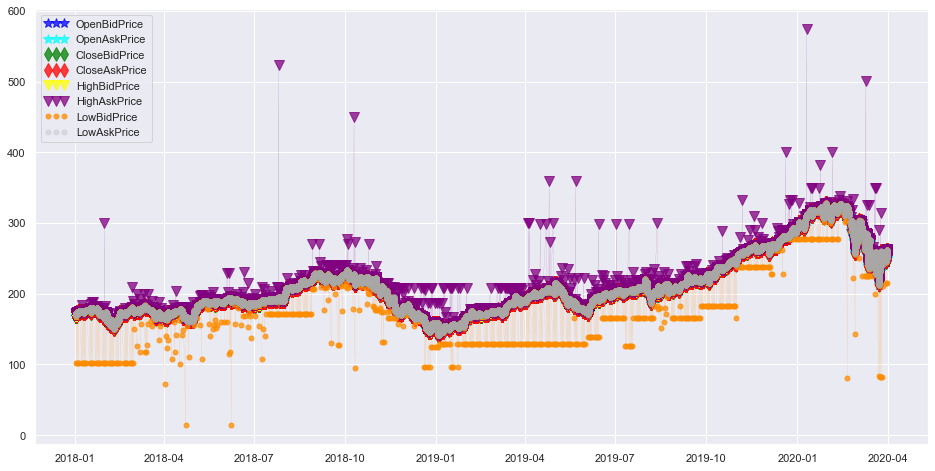

In [28]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
sns.set_style("white")
sns.set(rc={'figure.figsize':(16,8)})
import numpy as np
import pandas as pd

j = bigF.loc[bigF['Ticker'] == "AAPL"]
j = j[['Date','OpenBarTime','OpenBidPrice','OpenAskPrice','CloseBidPrice','CloseAskPrice','HighBidPrice','HighAskPrice','LowBidPrice','LowAskPrice']].copy()

j['Date'] = pd.to_datetime(j['Date'].astype(str))
j['Time'] = pd.to_timedelta(j['OpenBarTime'].astype(str))
j['DateTime'] = pd.to_datetime(j['Date'].astype(str)) + pd.to_timedelta(j['OpenBarTime'].astype(str))

line1, = plt.plot(j[['OpenBidPrice']], color='blue', linestyle='solid', linewidth=0.1, marker='*', ms='10', alpha = 0.75, label='OpenBidPrice')
line2, = plt.plot(j[['OpenAskPrice']], color='cyan', linestyle='solid', linewidth=0.1, marker='*', ms='10', alpha = 0.75, label='OpenAskPrice')
line3, = plt.plot(j[['CloseBidPrice']], color='green', linestyle='solid', linewidth=0.1, marker='d', ms='10', alpha = 0.75, label='CloseBidPrice')
line4, = plt.plot(j[['CloseAskPrice']], color='red', linestyle='solid', linewidth=0.1, marker='d', ms='10', alpha = 0.75, label='CloseAskPrice')
line5, = plt.plot(j[['HighBidPrice']], color='yellow', linestyle='solid', linewidth=0.1, marker='v', ms='10', alpha = 0.75, label='HighBidPrice')
line6, = plt.plot(j[['HighAskPrice']], color='purple', linestyle='solid', linewidth=0.1, marker='v', ms='10', alpha = 0.75, label='HighAskPrice')
line7, = plt.plot(j[['LowBidPrice']], color='darkorange', linestyle='solid', linewidth=0.1, marker='.', ms='10', alpha = 0.75, label='LowBidPrice')
line8, = plt.plot(j[['LowAskPrice']], color='darkgrey', linestyle='solid', linewidth=0.1, marker='.', ms='10', alpha = 0.25, label='LowAskPrice')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=3),
                        line2: HandlerLine2D(numpoints=3),
                        line3: HandlerLine2D(numpoints=3),
                        line4: HandlerLine2D(numpoints=3),
                        line5: HandlerLine2D(numpoints=3),
                        line6: HandlerLine2D(numpoints=3),
                        line7: HandlerLine2D(numpoints=3),
                        line8: HandlerLine2D(numpoints=3)});

*Figure [X]. Open, High, Low, Close Bid/Ask prices plotted separately as a grid, for comparison*

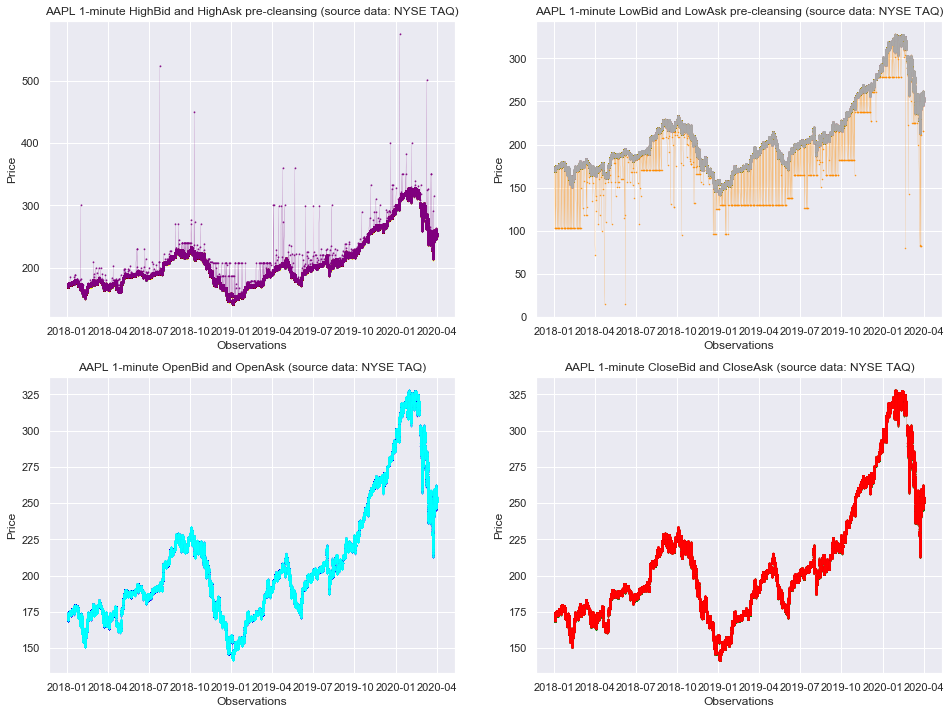

In [29]:
from scipy import stats
import seaborn as sns; sns.set()
from seaborn_qqplot import qqplot
import numpy as np
import pandas as pd
np.random.seed(7654321)
fig = plt.figure(figsize=(16,12)) 

j = bigF.loc[bigF['Ticker'] == "AAPL"]
j = j[['Date','OpenBarTime','OpenBidPrice','OpenAskPrice','CloseBidPrice','CloseAskPrice','HighBidPrice','HighAskPrice','LowBidPrice','LowAskPrice']].copy()

j['Date'] = pd.to_datetime(j['Date'].astype(str))
j['Time'] = pd.to_timedelta(j['OpenBarTime'].astype(str))
j['DateTime'] = pd.to_datetime(j['Date'].astype(str)) + pd.to_timedelta(j['OpenBarTime'].astype(str))

ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute HighBid and HighAsk pre-cleansing (source data: NYSE TAQ)", xlabel="Observations", ylabel="Price");
line5, = plt.plot(j[['HighBidPrice']], color='yellow', linestyle='solid', linewidth=0.1, marker='v', ms='1', alpha = 1, label='HighBidPrice')
line6, = plt.plot(j[['HighAskPrice']], color='purple', linestyle='solid', linewidth=0.1, marker='v', ms='1', alpha = 1, label='HighAskPrice')

ax1 = plt.subplot(222)
ax1.set(title="AAPL 1-minute LowBid and LowAsk pre-cleansing (source data: NYSE TAQ)", xlabel="Observations", ylabel="Price");
line7, = plt.plot(j[['LowBidPrice']], color='darkorange', linestyle='solid', linewidth=0.1, marker='.', ms='1', alpha = 1, label='LowBidPrice')
line8, = plt.plot(j[['LowAskPrice']], color='darkgrey', linestyle='solid', linewidth=0.1, marker='.', ms='1', alpha = 1, label='LowAskPrice')

ax1 = plt.subplot(223)
ax1.set(title="AAPL 1-minute OpenBid and OpenAsk (source data: NYSE TAQ)", xlabel="Observations", ylabel="Price");
ax1.plot(j[['OpenBidPrice']], color='blue', linestyle='solid', linewidth=0.1, marker='*', ms='1', alpha = 1, label='OpenBidPrice')
ax1.plot(j[['OpenAskPrice']], color='cyan', linestyle='solid', linewidth=0.1, marker='*', ms='1', alpha = 1, label='OpenAskPrice')

ax1 = plt.subplot(224)
ax1.set(title="AAPL 1-minute CloseBid and CloseAsk (source data: NYSE TAQ)", xlabel="Observations", ylabel="Price");
line3, = plt.plot(j[['CloseBidPrice']], color='green', linestyle='solid', linewidth=0.1, marker='d', ms='1', alpha = 1, label='CloseBidPrice')
line4, = plt.plot(j[['CloseAskPrice']], color='red', linestyle='solid', linewidth=0.1, marker='d', ms='1', alpha = 1, label='CloseAskPrice')

plt.show();

*Figure [X]. HighAsk and LowBid prices*

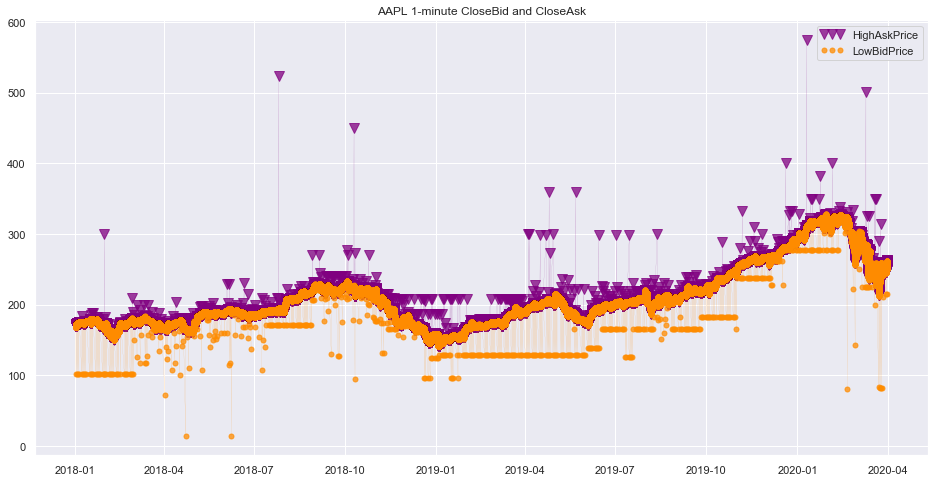

In [30]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
sns.set_style("white")
sns.set(rc={'figure.figsize':(16,8)})
import numpy as np
import pandas as pd

j = bigF.loc[bigF['Ticker'] == "AAPL"]
j = j[['Date','OpenBarTime','OpenBidPrice','OpenAskPrice','CloseBidPrice','CloseAskPrice','HighBidPrice','HighAskPrice','LowBidPrice','LowAskPrice']].copy()

j['Date'] = pd.to_datetime(j['Date'].astype(str))
j['Time'] = pd.to_timedelta(j['OpenBarTime'].astype(str))
j['DateTime'] = pd.to_datetime(j['Date'].astype(str)) + pd.to_timedelta(j['OpenBarTime'].astype(str))

line1, = plt.plot(j[['HighAskPrice']], color='purple', linestyle='solid', linewidth=0.1, marker='v', ms='10', alpha = 0.75, label='HighAskPrice')
line2, = plt.plot(j[['LowBidPrice']], color='darkorange', linestyle='solid', linewidth=0.1, marker='.', ms='10', alpha = 0.75, label='LowBidPrice')

plt.title('AAPL 1-minute CloseBid and CloseAsk');

plt.legend(handler_map={line1: HandlerLine2D(numpoints=3),
                        line2: HandlerLine2D(numpoints=3)});

## Time series and log returns superimposed | i.e. as per Paper 2 intro

*Figure X. AAPL price time series and log returns from 01-01-2018 to 31-03-2020*

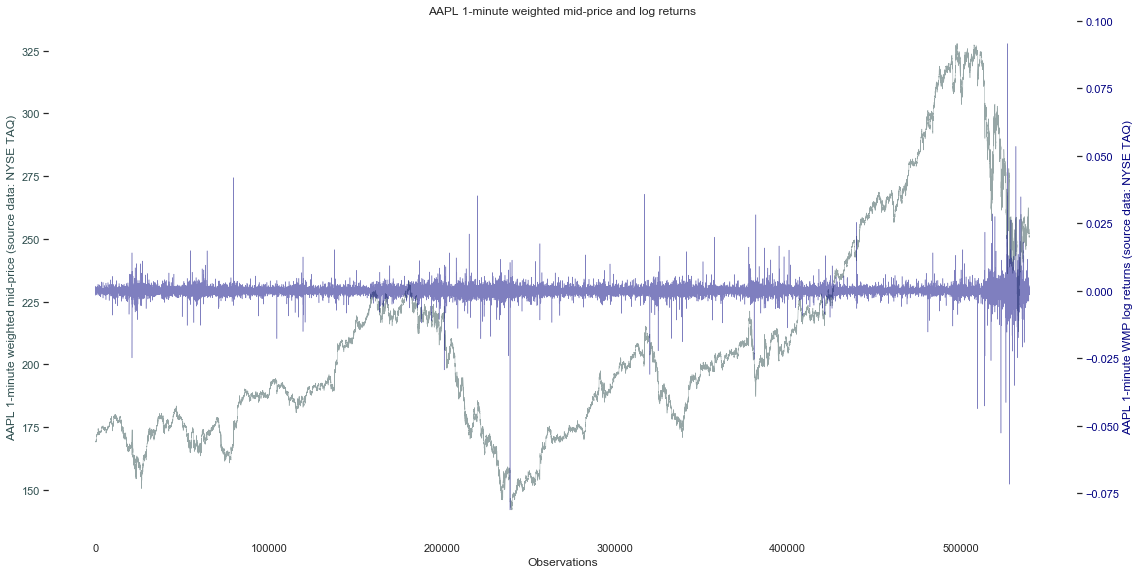

In [31]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set(rc={'figure.figsize':(16,8)})
import numpy as np

j = smF.loc[smF['Ticker'] == "AAPL"]
j = j['WeightedMidPrice']
j = j[j.notna()].copy()
j = j[j != 0].copy()

k = np.log(j.astype(float))
k = k - k.shift(1)

# Remove outliers
Q1l = k.quantile(0.00001)   # Start with these quantile values, experiment with lower values
Q3l = k.quantile(0.99999)   # Start with these quantile values, experiment with lower values if necessary
IQl = Q3l - Q1l
k = k[~((k < (Q1l - 1.5 * IQl)) | (k > (Q3l + 1.5 * IQl)))]
m = len(k)
j = j[:m,]

n_steps = len(j)
t = np.arange(0, n_steps)
data1 = j
data2 = k

fig, ax1 = plt.subplots();
color = 'darkslategrey'
ax1.set_xlabel('Observations');
ax1.set_ylabel('AAPL 1-minute weighted mid-price (source data: NYSE TAQ)', color=color);
ax1.plot(t, data1, linestyle='-', linewidth=0.5, alpha=0.5, color = 'darkslategrey');
ax1.tick_params(axis='y', labelcolor=color);
ax1.set_facecolor('white')
ax1.grid(False)

ax2 = ax1.twinx();
color = 'navy'
ax2.set_ylabel('AAPL 1-minute WMP log returns (source data: NYSE TAQ)', color=color);
ax2.plot(t, data2, linestyle='-', linewidth=0.5, alpha=0.5, color = 'navy');
ax2.tick_params(axis='y', labelcolor=color);
ax2.set_facecolor('white')
ax2.grid(False)

fig.tight_layout();
plt.title("AAPL 1-minute weighted mid-price and log returns");

plt.show();

## Supplementary charts | Might be usefull

**AAPL**

*Figure X. AAPL HF Weighted Mid-Price data time series from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = smF.loc[smF['Ticker'] == "AAPL"]
j = j['WeightedMidPrice']

fig = plt.figure(figsize=(16,6))  
T = len(j)
ax = fig.add_subplot(111)
x = np.linspace(0,T,T)

# Plot AAPL
totalEntries = j.shape[0]
title = 'AAPL 1-minute bar Weighted Mid-Price (source: NYSE TAQ) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="Stock price (USD)") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:grey');

*Figure X. AAPL HF Weighted Mid-Price raw returns from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = AAPL_rr

fig = plt.figure(figsize=(16,6))  
T = len(j)
ax = fig.add_subplot(111)
x = np.linspace(0,T,T)

# Plot AAPL
totalEntries = j.shape[0]
title = 'AAPL 1-minute bar Weighted Mid-Price raw returns (source: NYSE TAQ) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="Raw return") 

# ax.set(title='DEXJPUS Returns ' + ' (' + str(T) + ' observations)', xlabel="Observations", ylabel="Returns") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:grey');

*Figure X. AAPL HF Weighted Mid-Price log returns from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = AAPL_lr

fig = plt.figure(figsize=(16,6)) 
ax = fig.add_subplot(111)
T = len(j)
x = np.linspace(0,T,T)

totalEntries = j.shape[0]
title = 'AAPL 1-minute bar Weighted Mid-Price log returns (source: NYSE TAQ) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="Log return") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:grey');

# DOES SHOWING Y-AXIS AS A % MAKE SENSE IN THE CONTEXT OF LOG RETURNS?
# ax.yaxis.set_major_formatter(PercentFormatter())

# Show the plot
plt.show();

**JPM**

*Figure X. JPM HF Weighted Mid-Price data time series from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = smF.loc[smF['Ticker'] == "JPM"]
j = j['WeightedMidPrice']
fig = plt.figure(figsize=(16,6))  
T = len(j)
ax = fig.add_subplot(111)
x = np.linspace(0,T,T)
totalEntries = j.shape[0]
title = 'JPM 1-minute bar Weighted Mid Price (source: NYSE TAQ) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="Stock price (USD)") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:brown');

*Figure X. JPM HF Weighted Mid-Price raw returns from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = JPM_rr

fig = plt.figure(figsize=(16,6))  
T = len(j)
ax = fig.add_subplot(111)
x = np.linspace(0,T,T)
totalEntries = j.shape[0]
title = 'JPM 1-minute bar Weighted Mid-Price raw returns (source: NYSE TAQ) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="% Raw return") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:brown');

*Figure X. JPM HF Weighted Mid-Price log returns from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = JPM_lr

fig = plt.figure(figsize=(16,6)) 
ax = fig.add_subplot(111)
T = len(j)
x = np.linspace(0,T,T)
totalEntries = j.shape[0]
title = 'JPM 1-minute bar weighted mid price log returns (source: NYSE TAQ) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="Log return") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:brown');

# DOES SHOWING Y-AXIS AS A % MAKE SENSE IN THE CONTEXT OF LOG RETURNS?
# ax.yaxis.set_major_formatter(PercentFormatter())

# Show the plot
plt.show();

**FX EURUSD HF (1-min returns)**

*Figure X. FX EURUSD HF Weighted Mid-Price data time series from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = dfFX['barCloseBid']

fig = plt.figure(figsize=(16,6))  
T = len(j)
ax = fig.add_subplot(111)
x = np.linspace(0,T,T)

# Plot AAPL
totalEntries = j.shape[0]
title = 'FX EURUSD HF Weighted Mid-Price (source: Tick Data) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="Exchange rate") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:orange');

*Figure X. FX EURUSD HF Weighted Mid-Price raw returns from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = rrFX

fig = plt.figure(figsize=(16,6))  
T = len(j)
ax = fig.add_subplot(111)
x = np.linspace(0,T,T)

# Plot AAPL
totalEntries = j.shape[0]
title = 'FX EURUSD HF Weighted Mid-Price (source: Tick Data) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="Raw return") 

# ax.set(title='DEXJPUS Returns ' + ' (' + str(T) + ' observations)', xlabel="Observations", ylabel="Returns") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:orange');

*Figure X. FX EURUSD HF Weighted Mid-Price log returns from 01-01-2018 to 31-03-2020*

In [ ]:
%matplotlib inline

j = lrFX

fig = plt.figure(figsize=(16,6)) 
ax = fig.add_subplot(111)
T = len(j)
x = np.linspace(0,T,T)

totalEntries = j.shape[0]
title = 'FX EURUSD HF Weighted Mid-Price (source: Tick Data) sampled between ' + startEndTimes[0] + ' and ' + startEndTimes[1]  + ' (' + str(totalEntries) + ' observations)'
ax.set(title=title, xlabel="Observations", ylabel="Log return") 
ax.plot(x, j, linestyle='-', linewidth=0.5, alpha=1, color = 'tab:orange');

# DOES SHOWING Y-AXIS AS A % MAKE SENSE IN THE CONTEXT OF LOG RETURNS?
# ax.yaxis.set_major_formatter(PercentFormatter())

# Show the plot
plt.show();

*Figure X. Simulated data and DEXJPUS log returns*

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(16,6))  
T = len(dat2)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
x = np.linspace(0,T,T)

# Plot simulated data
ax1.set(title='Simulated data ' + ' (' + str(T) + ' observations)', xlabel="Observations", ylabel="Simulated Return") 
ax1.plot(x, dat1, linestyle='-', linewidth=0.5, alpha=0.5, color = 'tab:blue')

# Plot DEXJPUS
ax2.set(title='DEXJPUS log Returns ' + ' (' + str(T) + ' observations)', xlabel="Observations", ylabel="Log Return") 
ax2.plot(x, dat2, linestyle='-', linewidth=0.5, alpha=0.5, color = 'tab:green')